Variables of filenames

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree2M_ml_DCM_12gev.root'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from bayes_opt import BayesianOptimization
# from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [3]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
m2LowerCut = -1
m2UpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    ELECTRON = 11
    # POSITRON = -11
    # ELECTRON = 11
    PROTON = 2212 
    # NEG_MUON = -13
    # POS_MUON = 13
    MUON = 13
    # NEG_PION = -211
    # POS_PION = 211 
    PION = 211
    # NEG_KAON = -321
    # POS_KAON = 321 
    KAON = 321
    BCKGR = 999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    # #t
    # size_t =  len(df['t'])
    # is_good_t = (df['t'] < tUpperCut)
    # percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    #mass2
    size_m2 =  len(df['mass2'])
    is_good_m2 = (df['mass2'] > m2LowerCut) & (df['mass2'] < m2UpperCut)
    percentage_m2 = ( size_m2 - len(df[is_good_m2]) ) / size_m2
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_m2) #& (is_good_t)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )
def sigma(df:pd.DataFrame, pid, nsigma=1, info=False):
    mean = df[df['pid']==pid]['mass2'].mean()
    std = df[df['pid']==pid]['mass2'].std()
    out_sigma = (df['pid']==pid) & ((df['mass2'] < (mean-nsigma*std)) | (df['mass2'] > (mean+nsigma*std)))
    df1 = df[~ out_sigma]
    if info:
        df_len = len(df)
        df1_len = len(df1)
        print('we get rid of ' + str ( round( ( df_len - df1_len) / df_len *100, 2)) + ' % of pid = ' 
              + str(pid) + ' particle entries')
    return df1

def xgb_preds(df, probaProton, probaKaon, probaPion):
    #getting max field
    df['xgb_preds']=df[[0, 1, 2]].idxmax(axis = 1)
    #setting to bckgr if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df[0] < probaProton )
    pion   = (df['xgb_preds'] == 1) & (df[1] < probaKaon )
    kaon   = (df['xgb_preds'] == 2) & (df[2] < probaPion )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 3
    return df

from collections import defaultdict
def remap_names(dataframe):
    return dataframe.pid.abs().map(defaultdict(lambda: 3, {Pid.PROTON.value : 0, Pid.KAON.value : 1,  Pid.PION.value : 2, Pid.MUON.value : 2}),na_action='ignore')#, Pid.ELECTRON.value : 2, 
 

In [4]:
import matplotlib as mpl
def sim_tof(df, pid):

    qp = df[df['pid']==pid]['q']*df[df['pid']==pid]['p']
    var_xaxis = qp
    mass2 = df[df['pid']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [5]:
%%capture
#Shahid's library for importing roottrees
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

In [6]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
gc.collect()
particles.iloc[0:10,:]

,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,1.928141,0.139570,-0.011916,1.572914,0.447987,-0.610026,0.367185,-0.256647,1.507769,1.883827,-211.0,-1.0
1,2.500318,0.139570,-0.009863,5.464226,0.890780,-1.681210,-0.098154,-0.885356,5.391130,2.488354,211.0,1.0
2,1.806927,0.139570,0.008711,2.865169,0.915995,-2.710099,-0.832037,-0.383095,2.714801,1.796060,-211.0,-1.0
3,2.115173,0.139570,0.017425,1.882905,0.447691,-2.514619,-0.362543,-0.262659,1.828908,2.070187,211.0,1.0
4,2.097679,0.938272,-0.237758,1.499275,0.362582,-2.560894,-0.303147,-0.198916,1.454771,1.164573,2212.0,-1.0
5,2.398703,0.493677,0.278050,1.294498,0.233248,-2.376918,-0.168314,-0.161478,1.273311,1.582983,321.0,1.0
6,2.667830,0.938272,0.796354,13.857271,1.914243,-2.004751,-0.804867,-1.736811,13.724418,2.561323,2212.0,1.0
7,2.572647,0.938272,0.868623,1.646631,0.249930,-1.007132,0.133534,-0.211266,1.627553,1.288680,2212.0,1.0
8,2.134996,0.139570,-0.041930,3.193019,0.744705,-0.563221,0.629678,-0.397607,3.104961,2.118219,-211.0,1.0
9,2.228435,0.493677,0.204404,1.916363,0.408040,-2.585814,-0.346626,-0.215284,1.872419,1.793962,321.0,1.0


Before 1 sigma selection

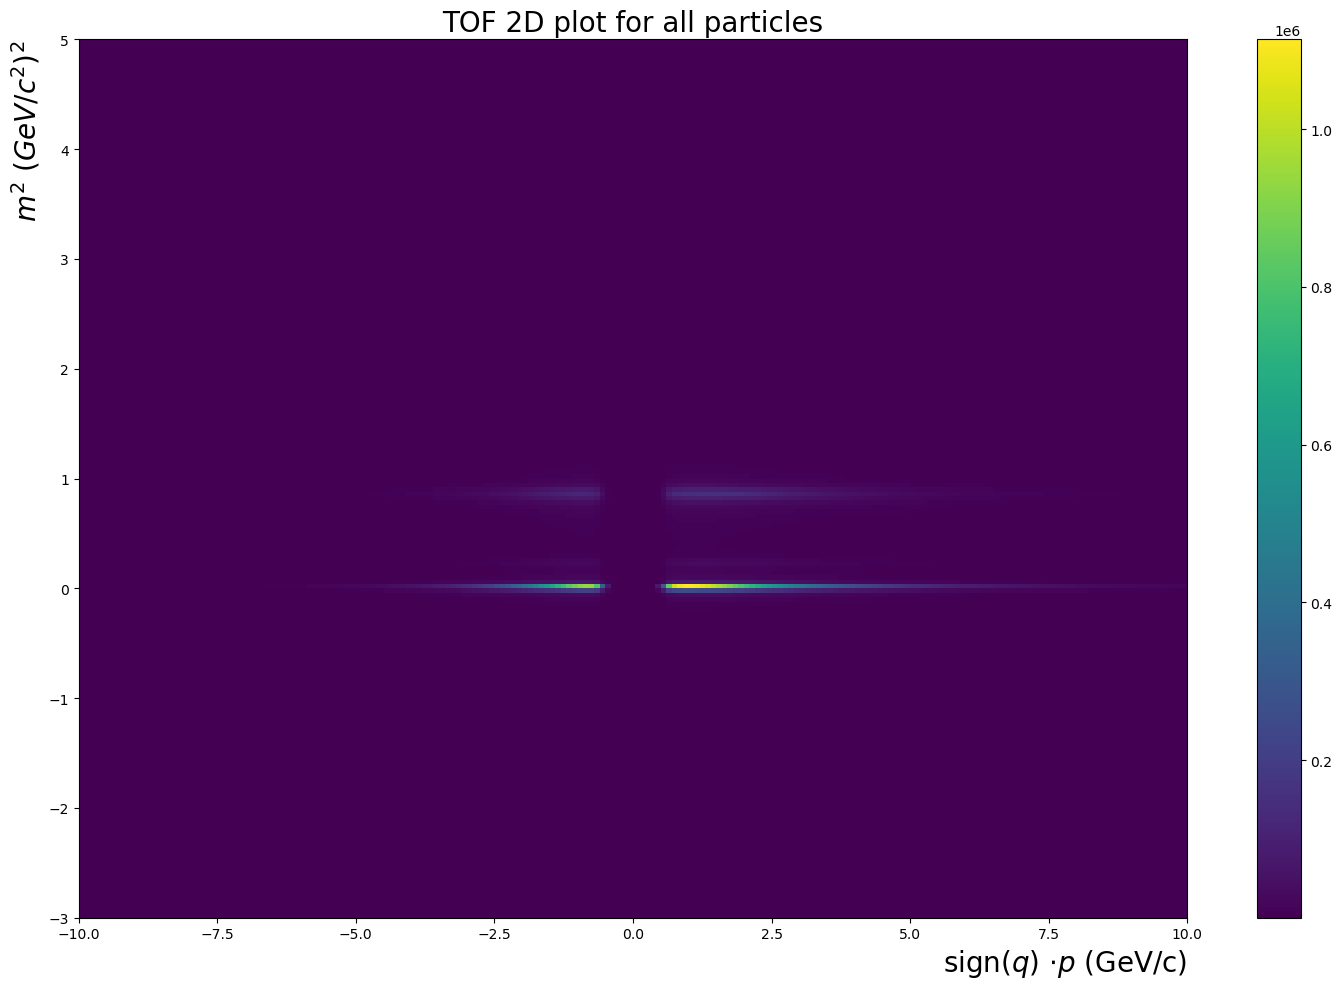

In [7]:
def all_tof(df):

    qp = df['q']*df['p']
    var_xaxis = qp
    mass2 = df['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-3, 5]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200,  range=ranges, vmin=10)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all particles'
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig
all_tof(particles)

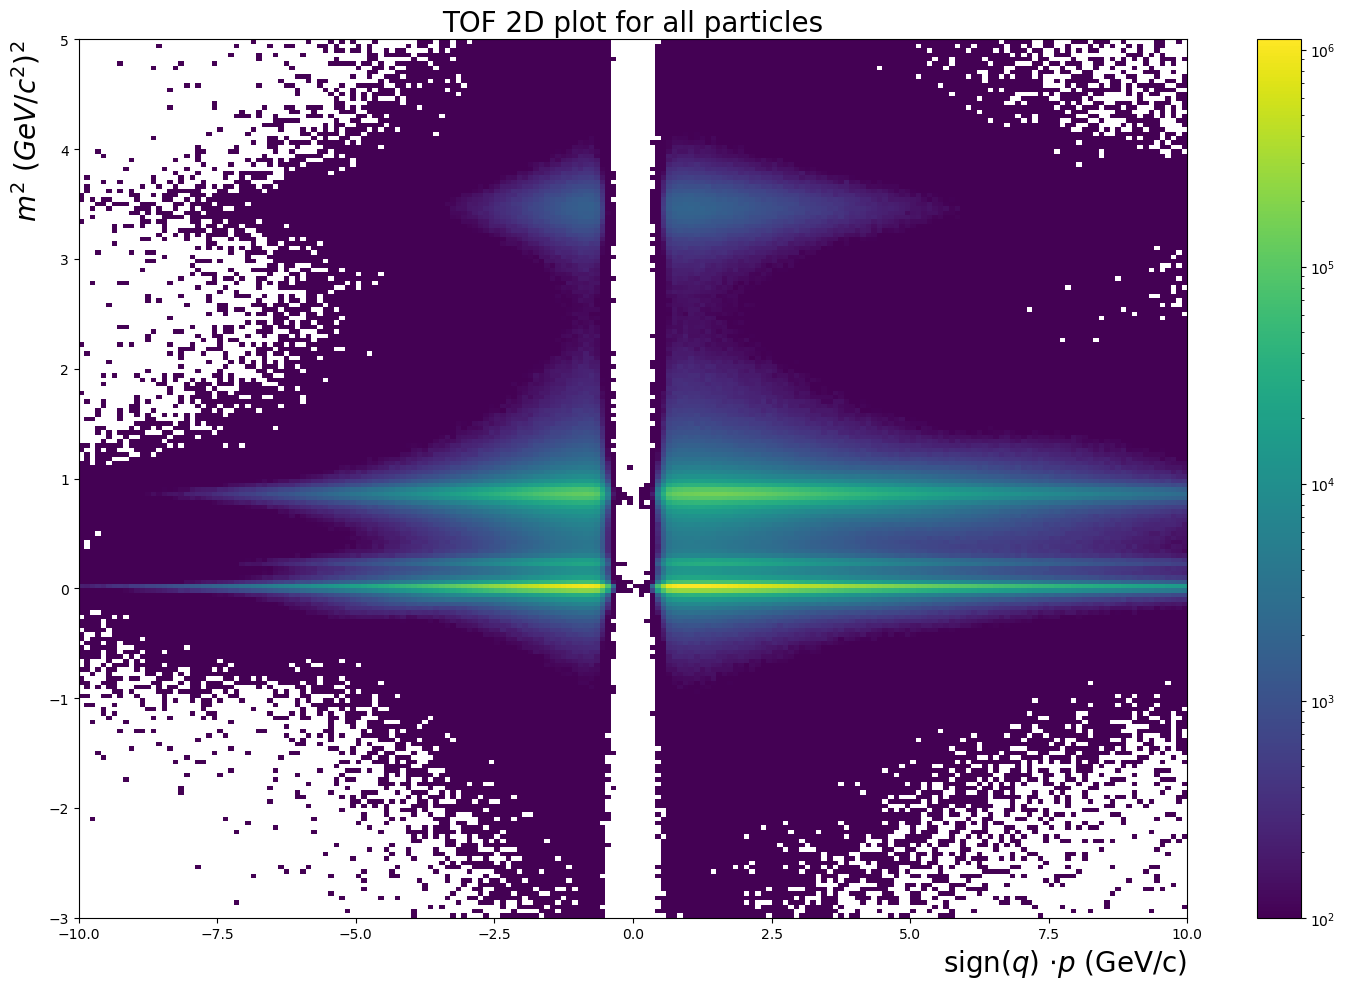

In [8]:
def all_tof(df):

    qp = df['q']*df['p']
    var_xaxis = qp
    mass2 = df['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-3, 5]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200,  norm=mpl.colors.LogNorm(vmin=100),  range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all particles'
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig
all_tof(particles)

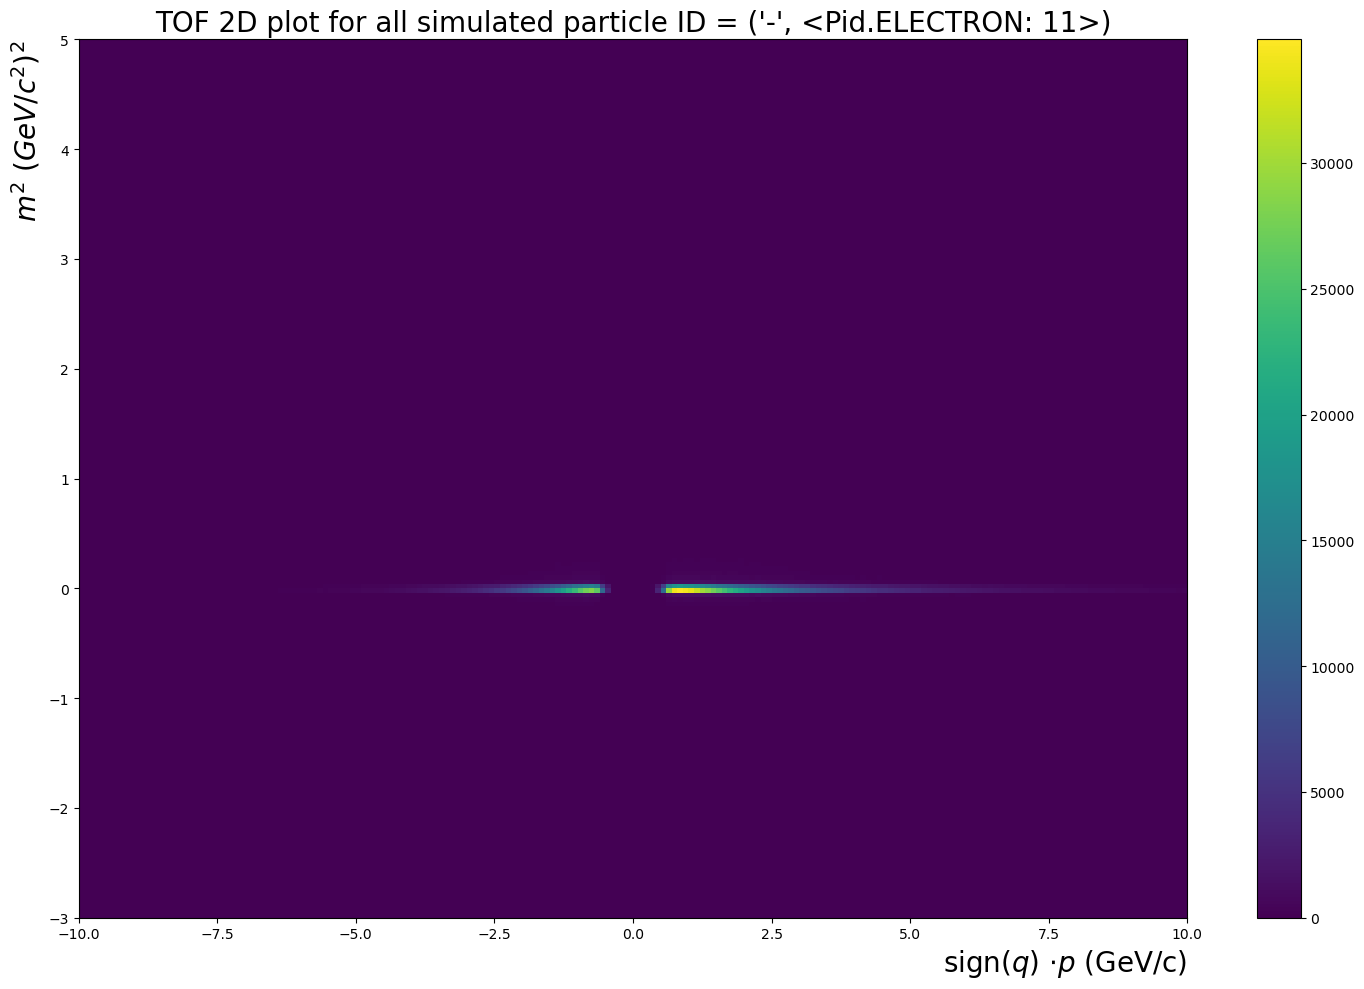

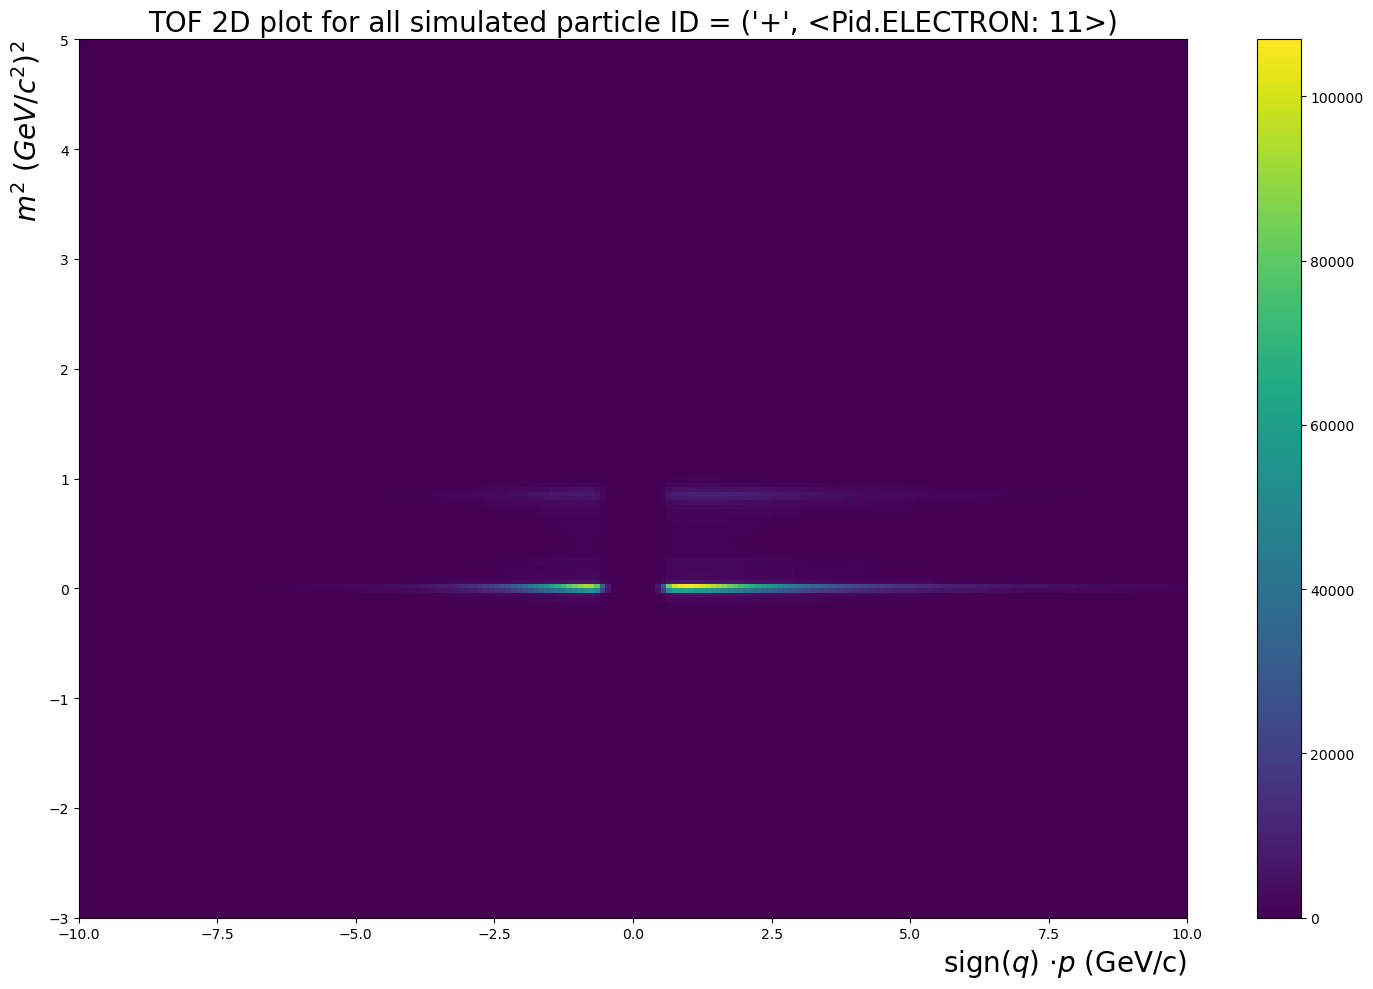

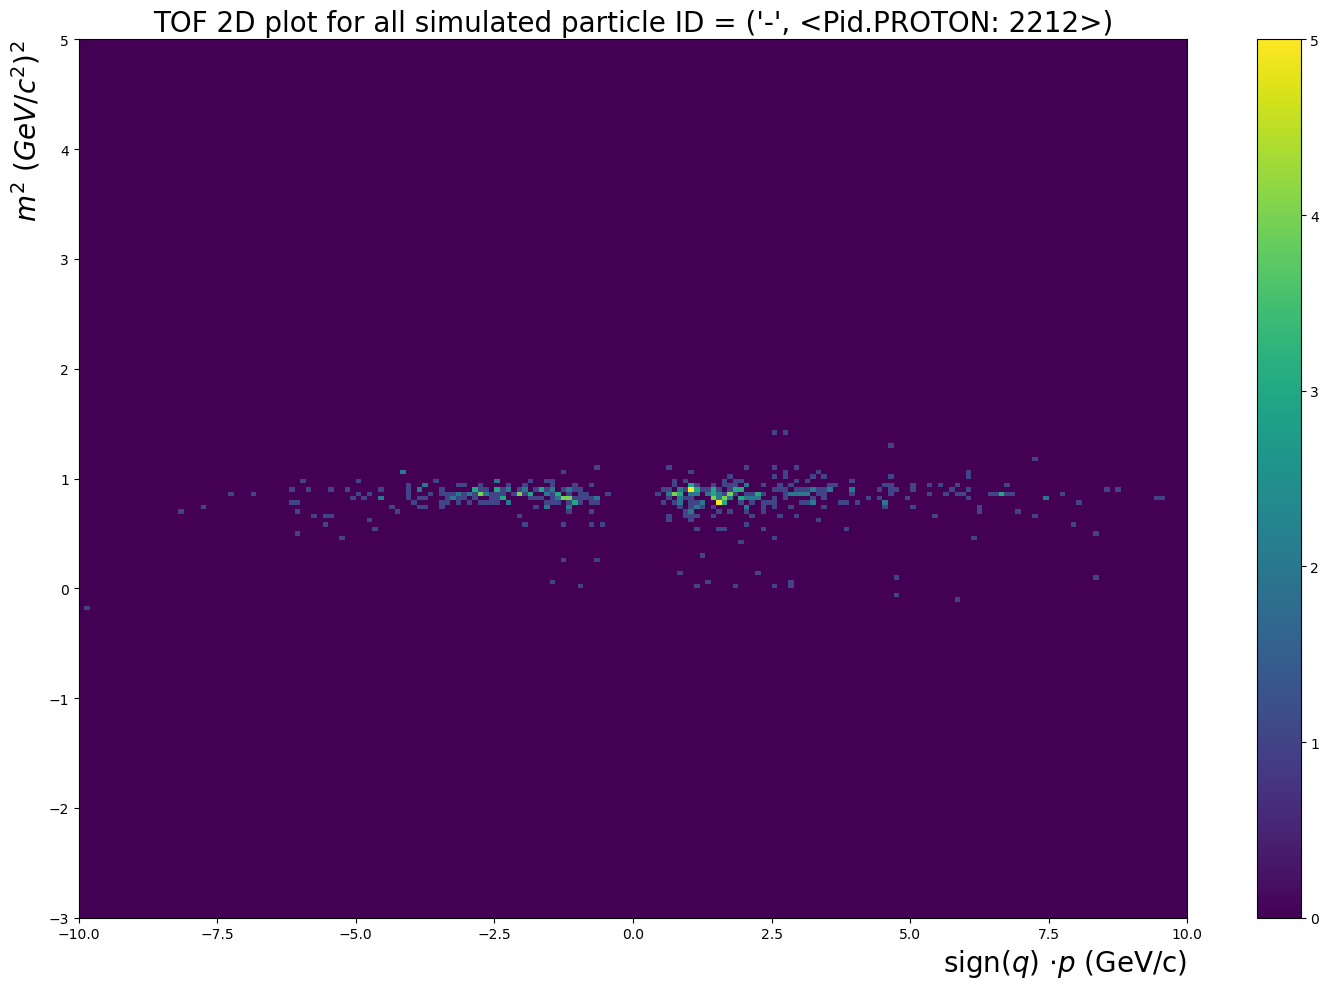

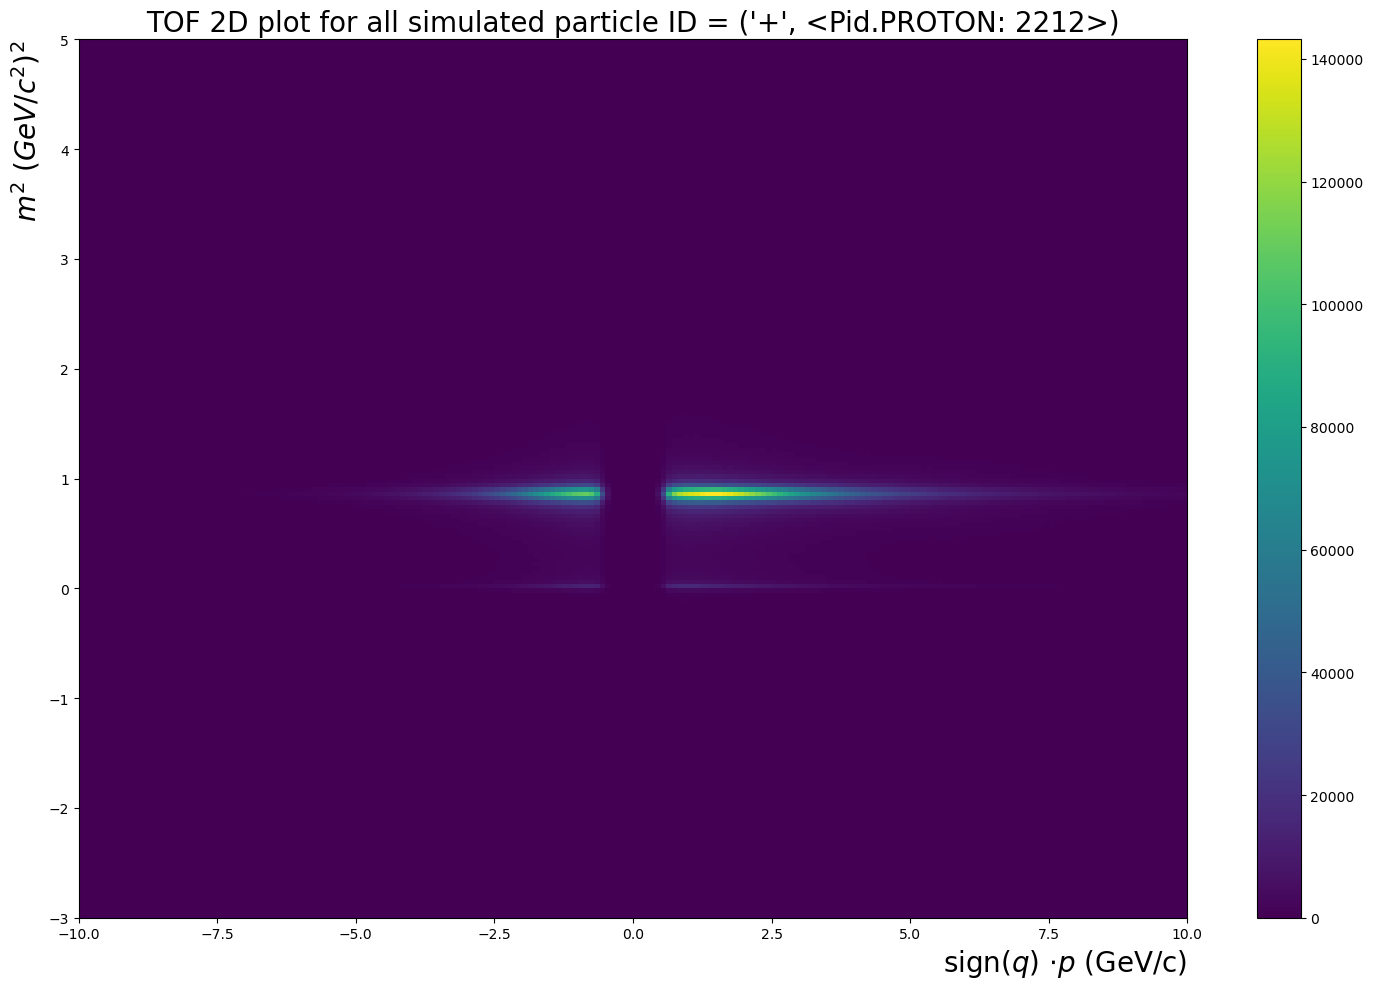

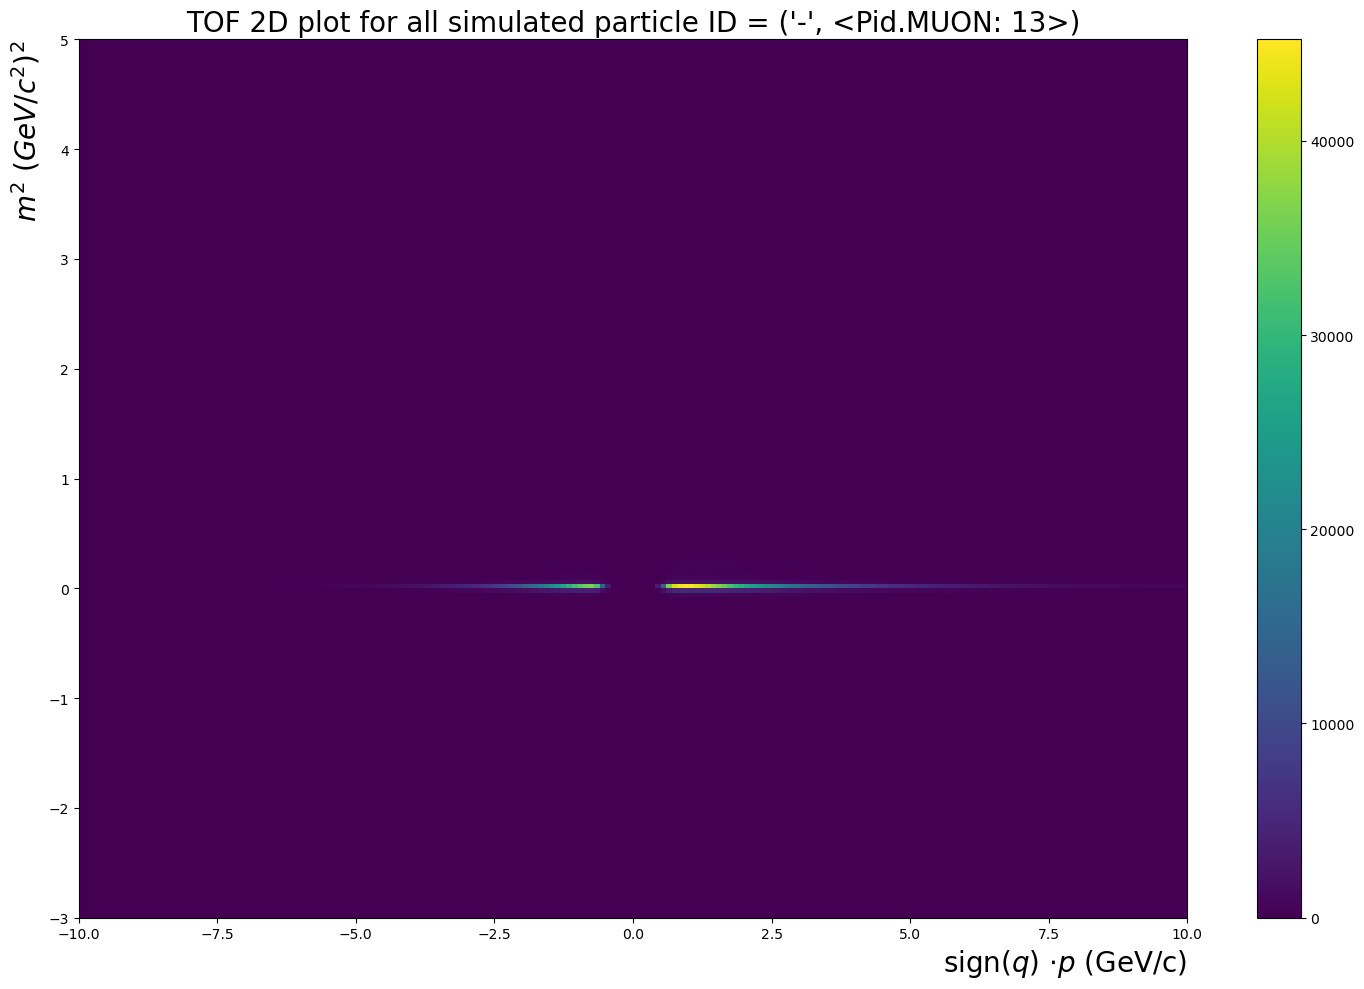

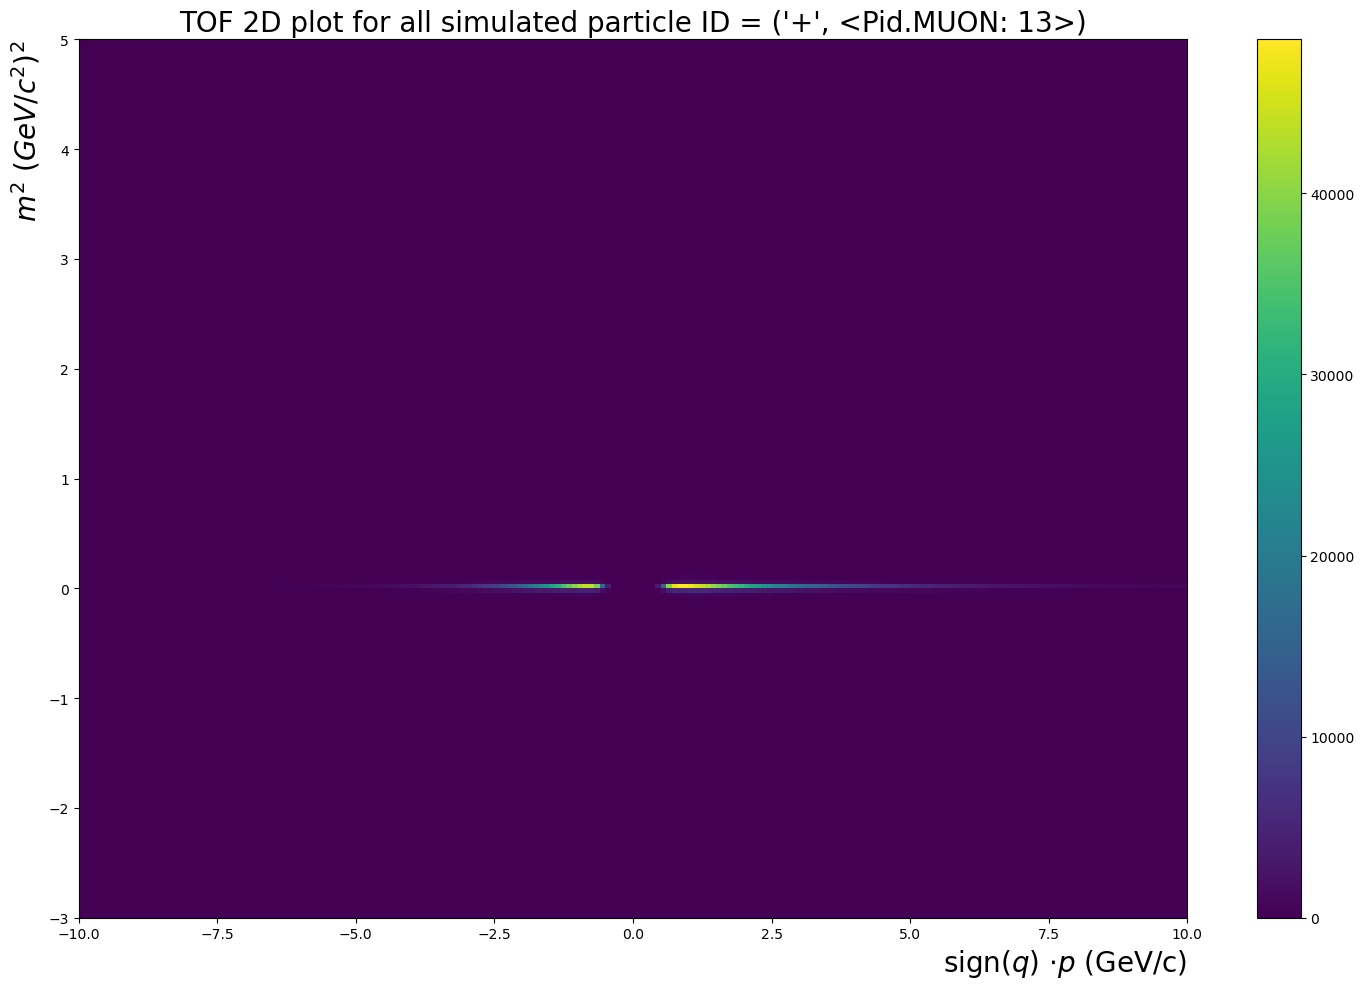

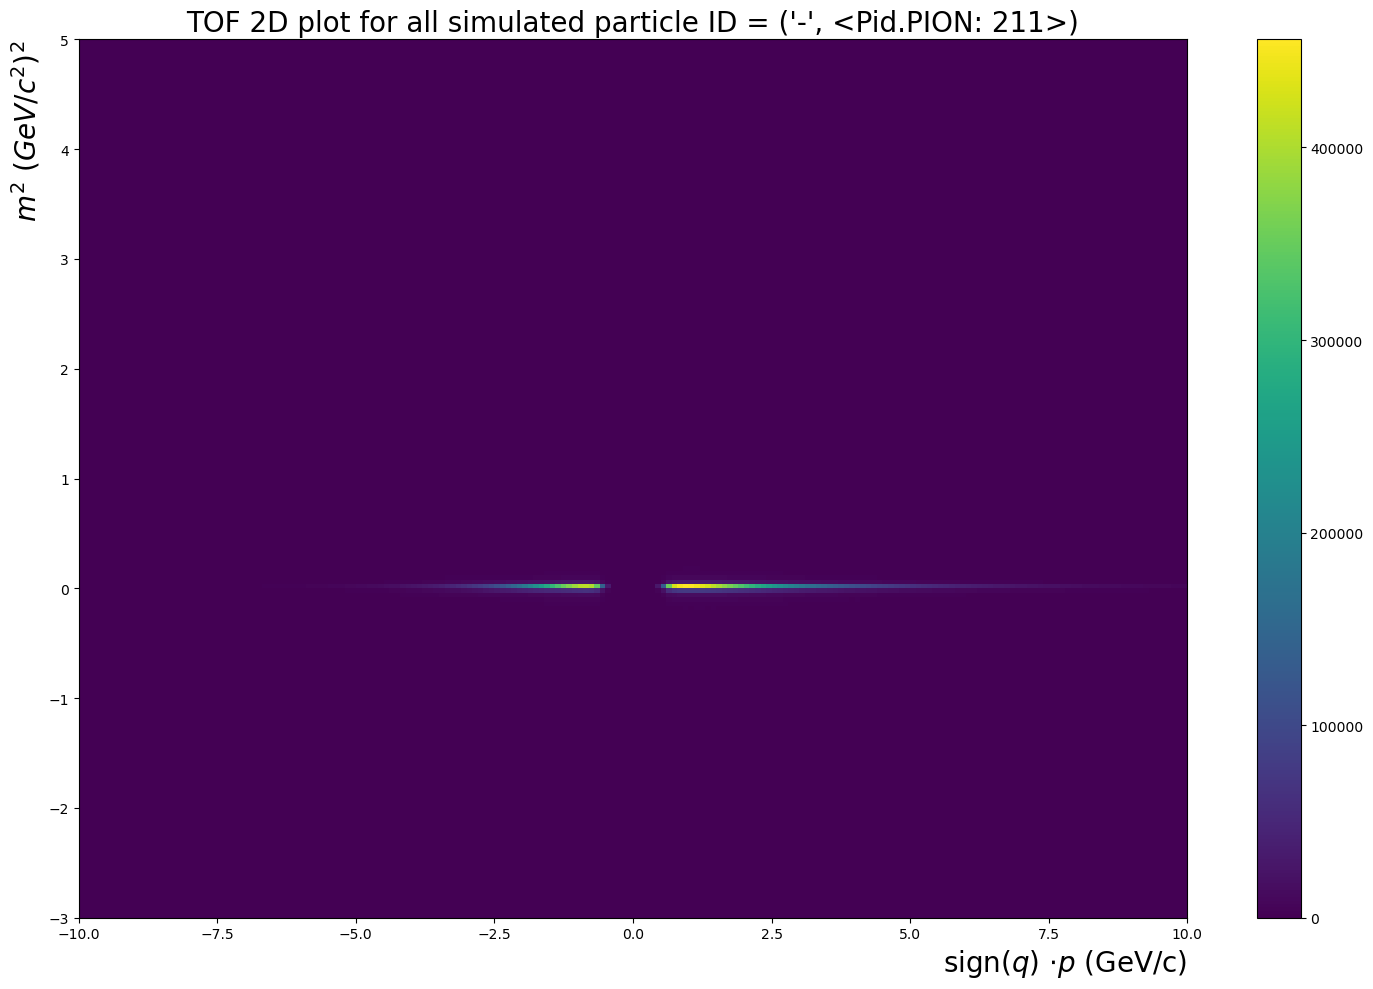

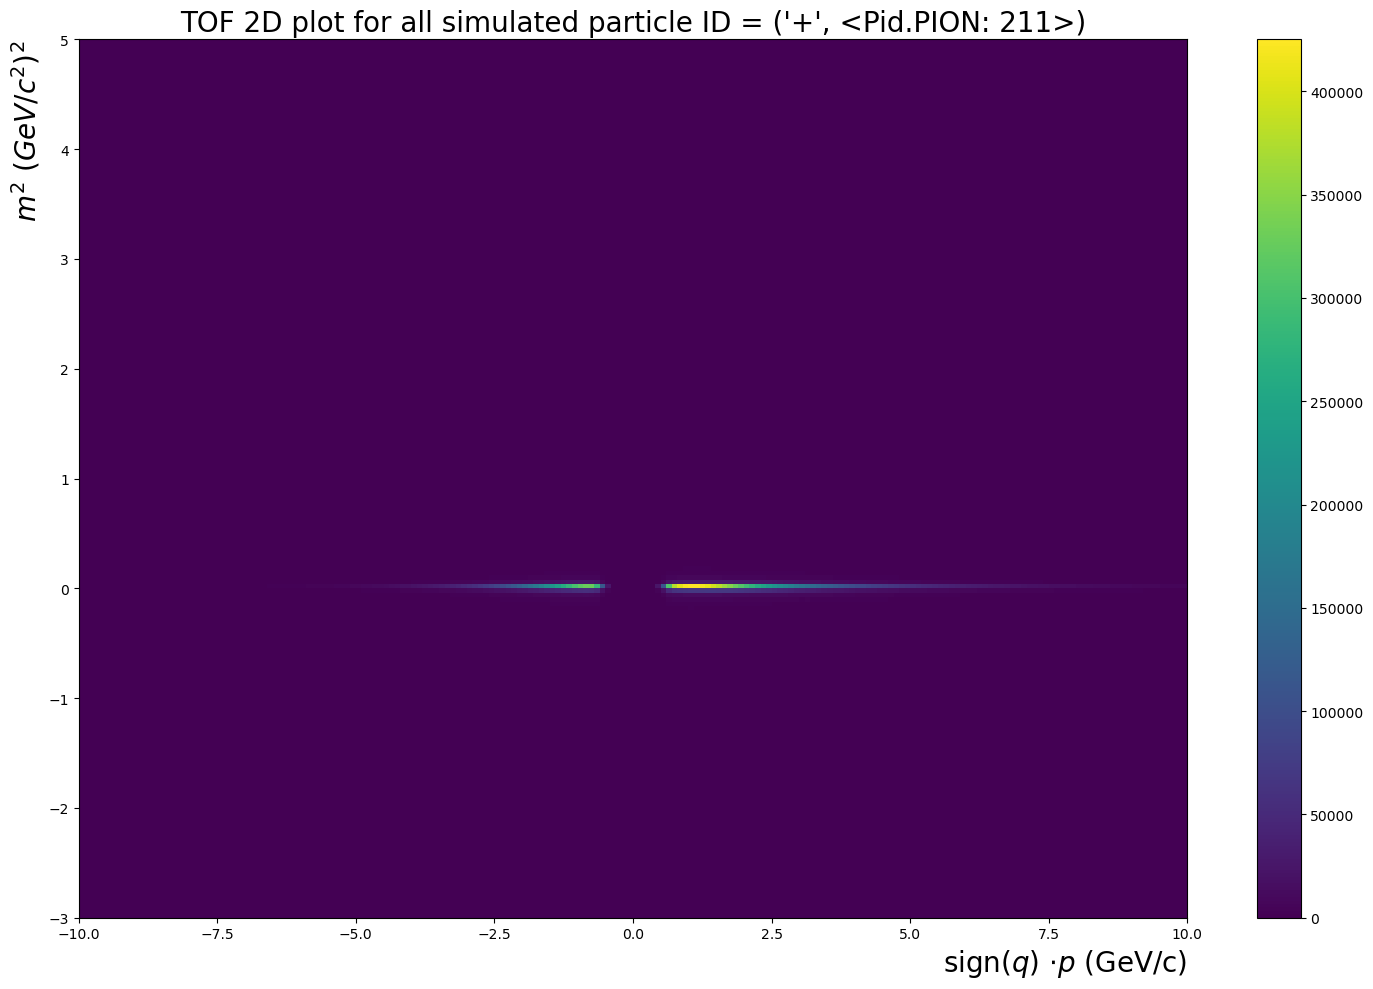

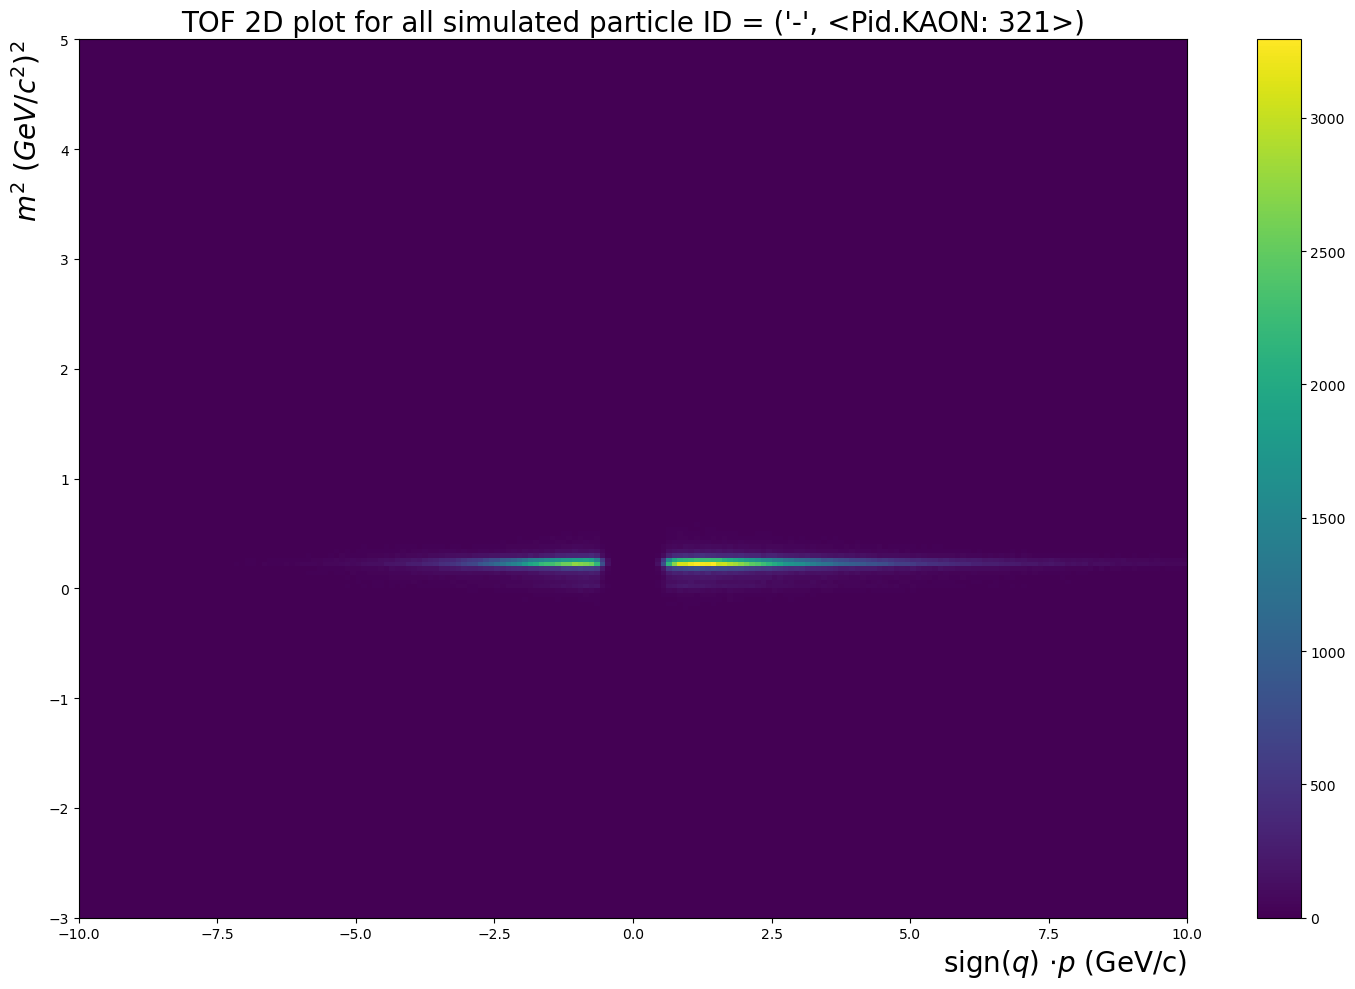

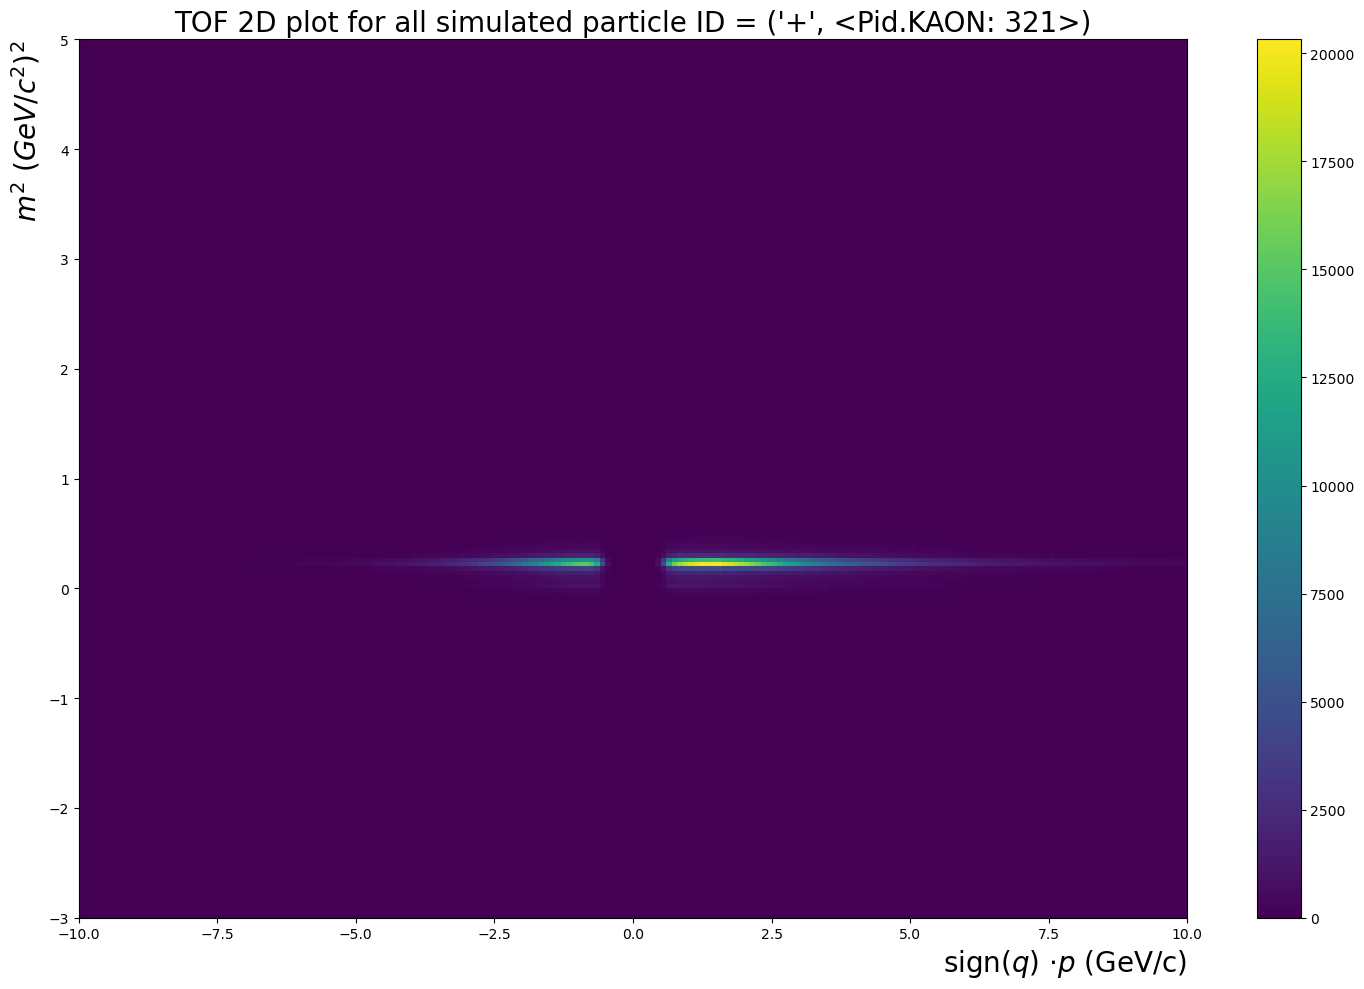

In [9]:
def classes_tof(df, pid, name, antip = 0):
    if antip == 0:
        df['pid'] = df['pid'].abs()
    part = df[df['pid']==pid]
    qp = part['q']*part['p']
    var_xaxis = qp
    mass2 = part['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-3, 5]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(name)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')
for pid in Pid:
    if pid != Pid.BCKGR:
        classes_tof(particles, -pid.value, ('-', pid), 1)
        classes_tof(particles, pid.value,  ('+', pid), 1)
        # classes_tof(particles, pid.value, pid)
        
# classes_tof(particles, -11,  'pid', 1)  

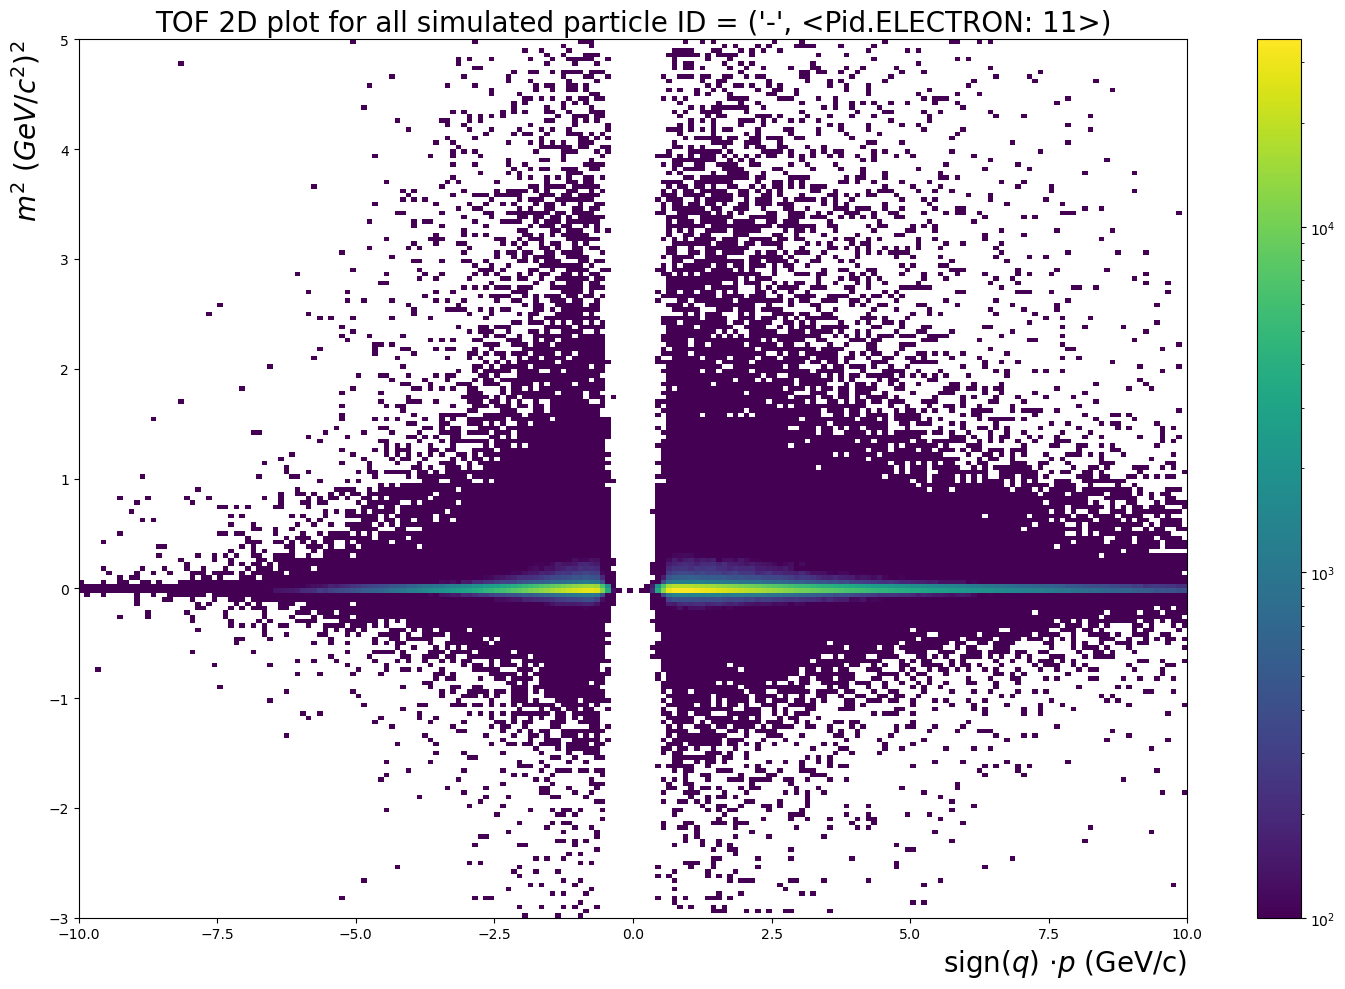

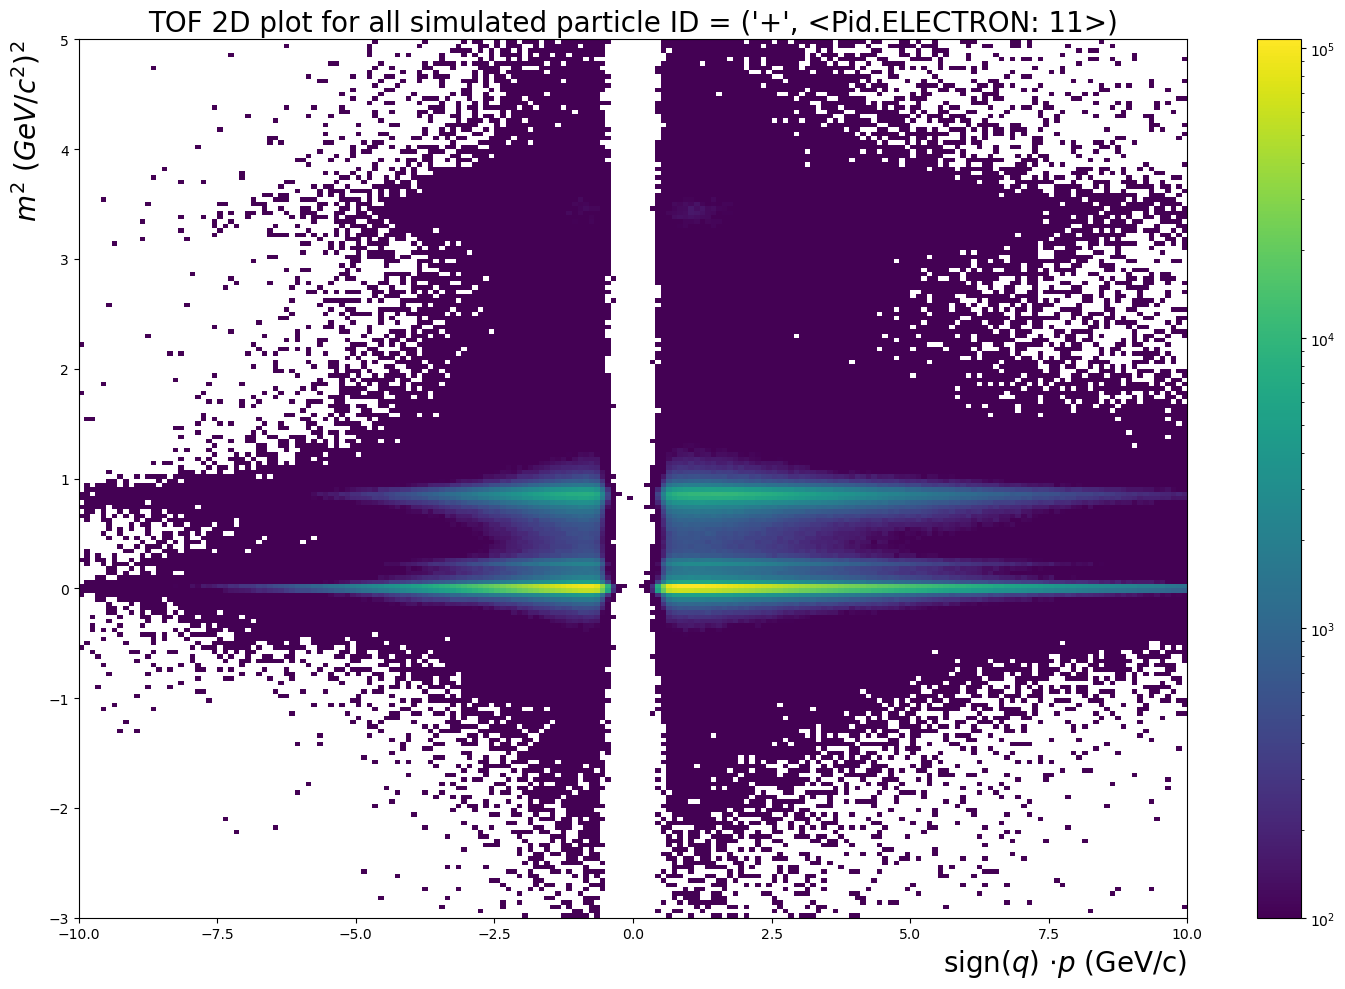

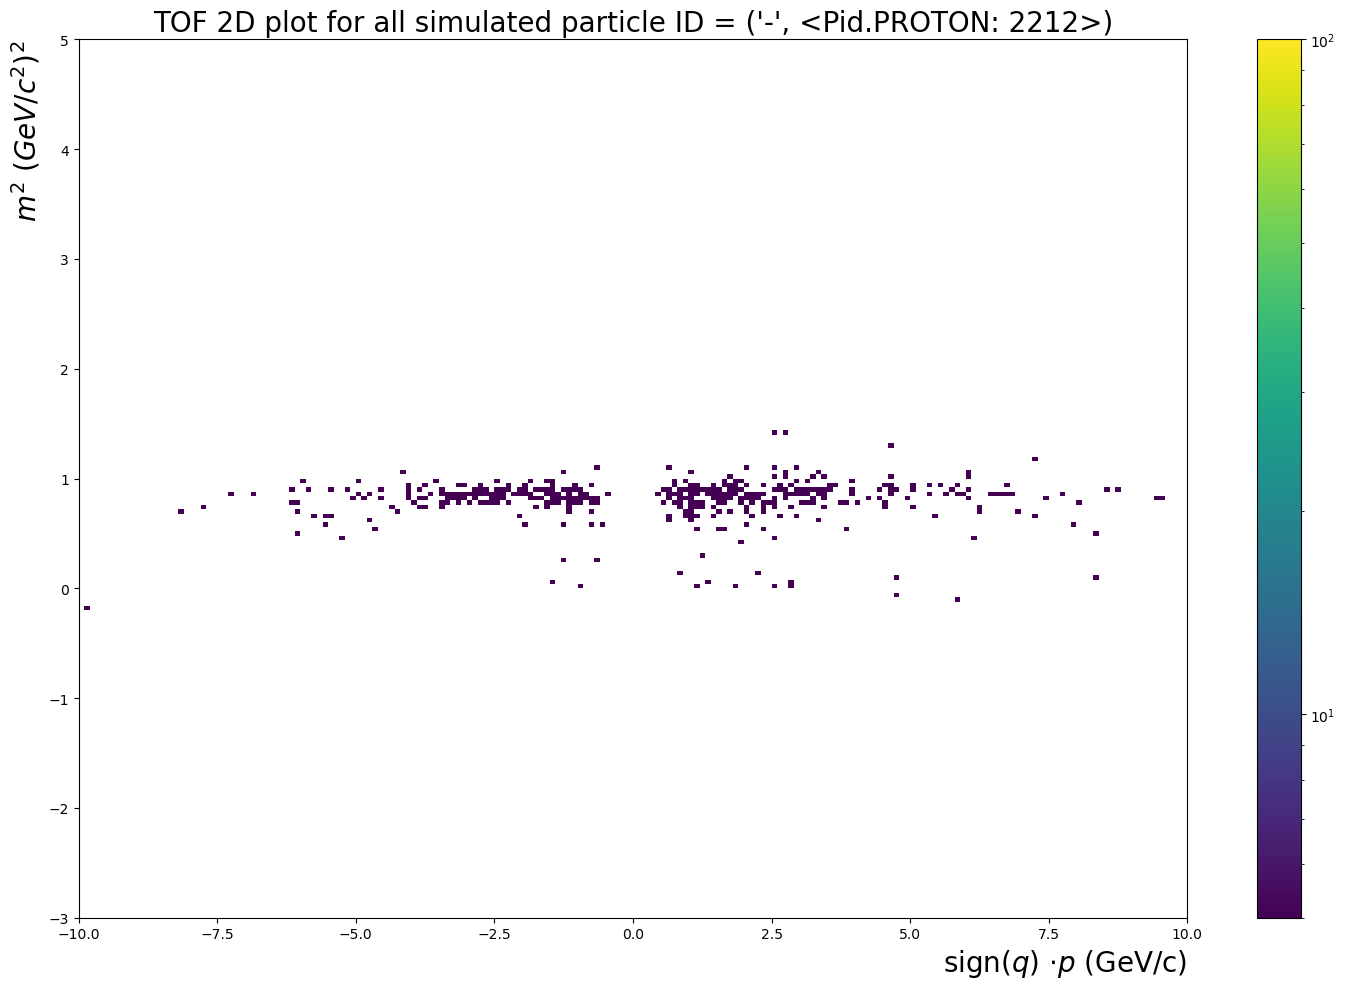

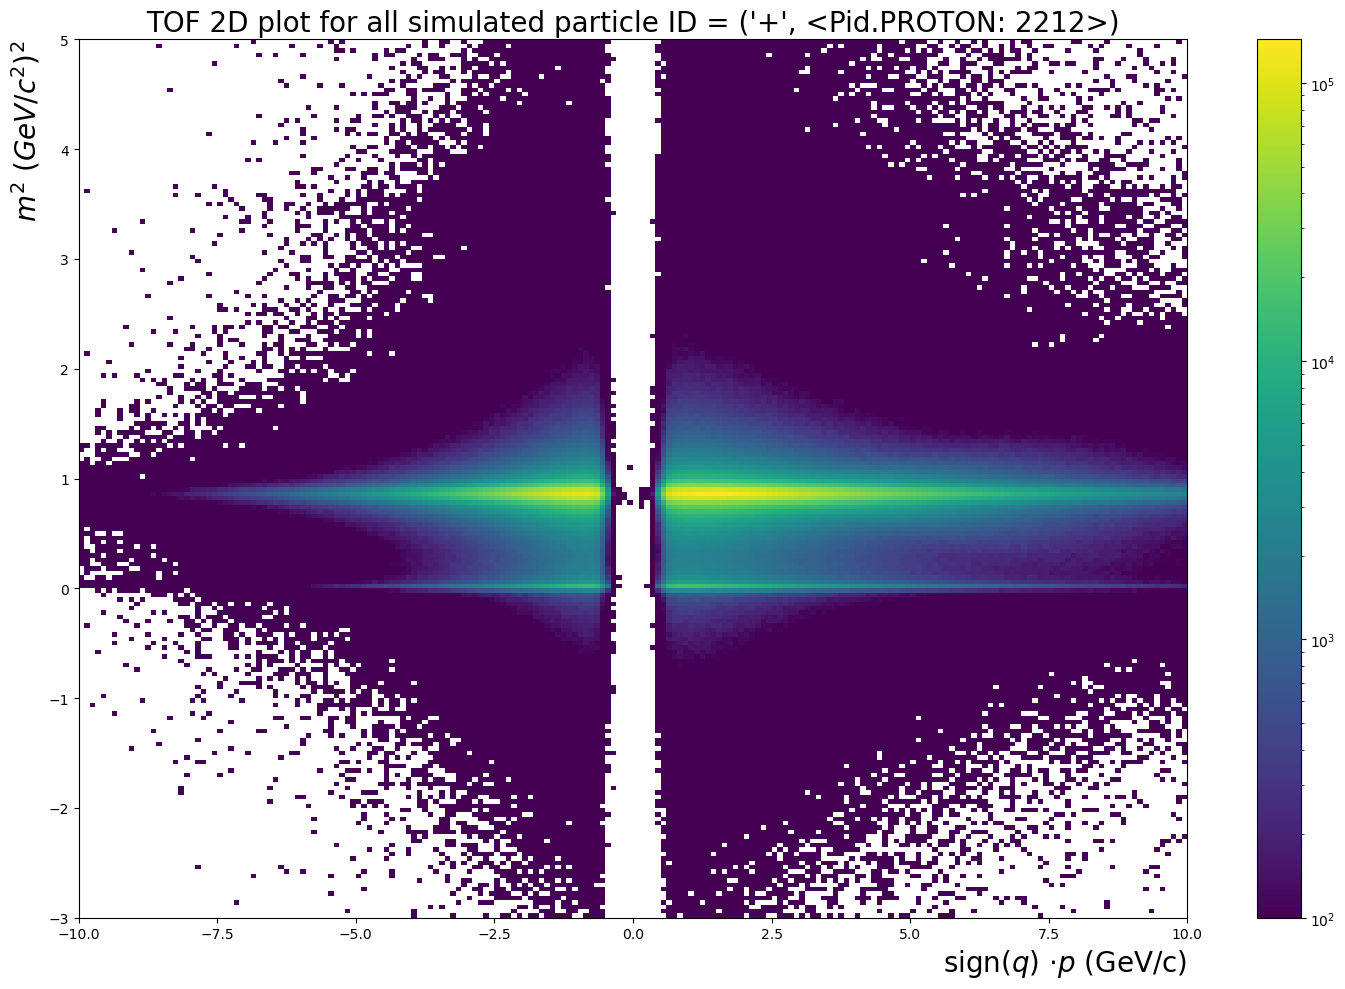

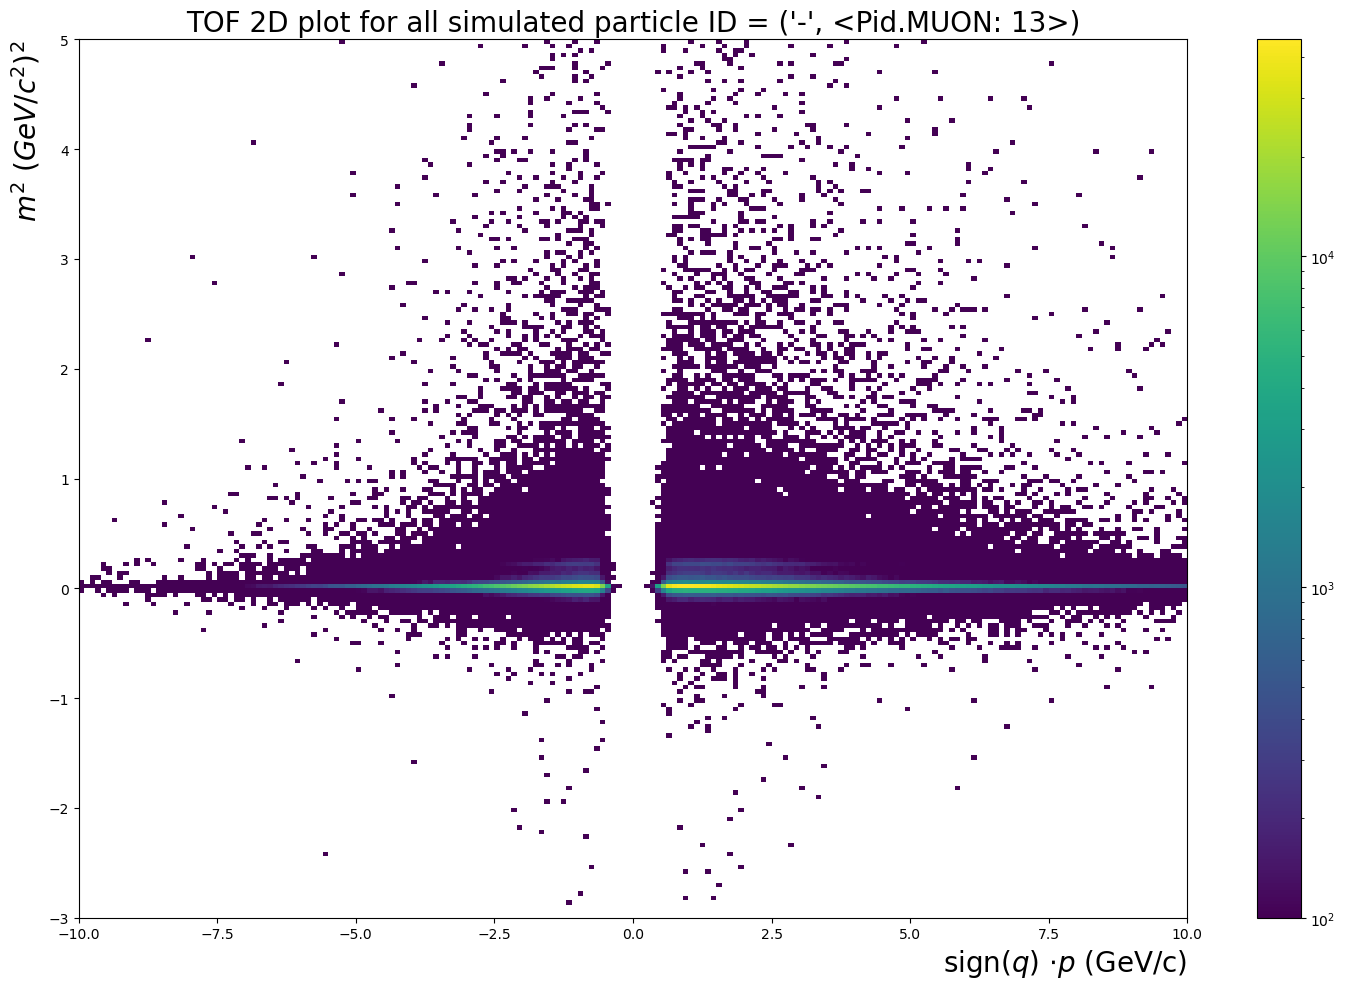

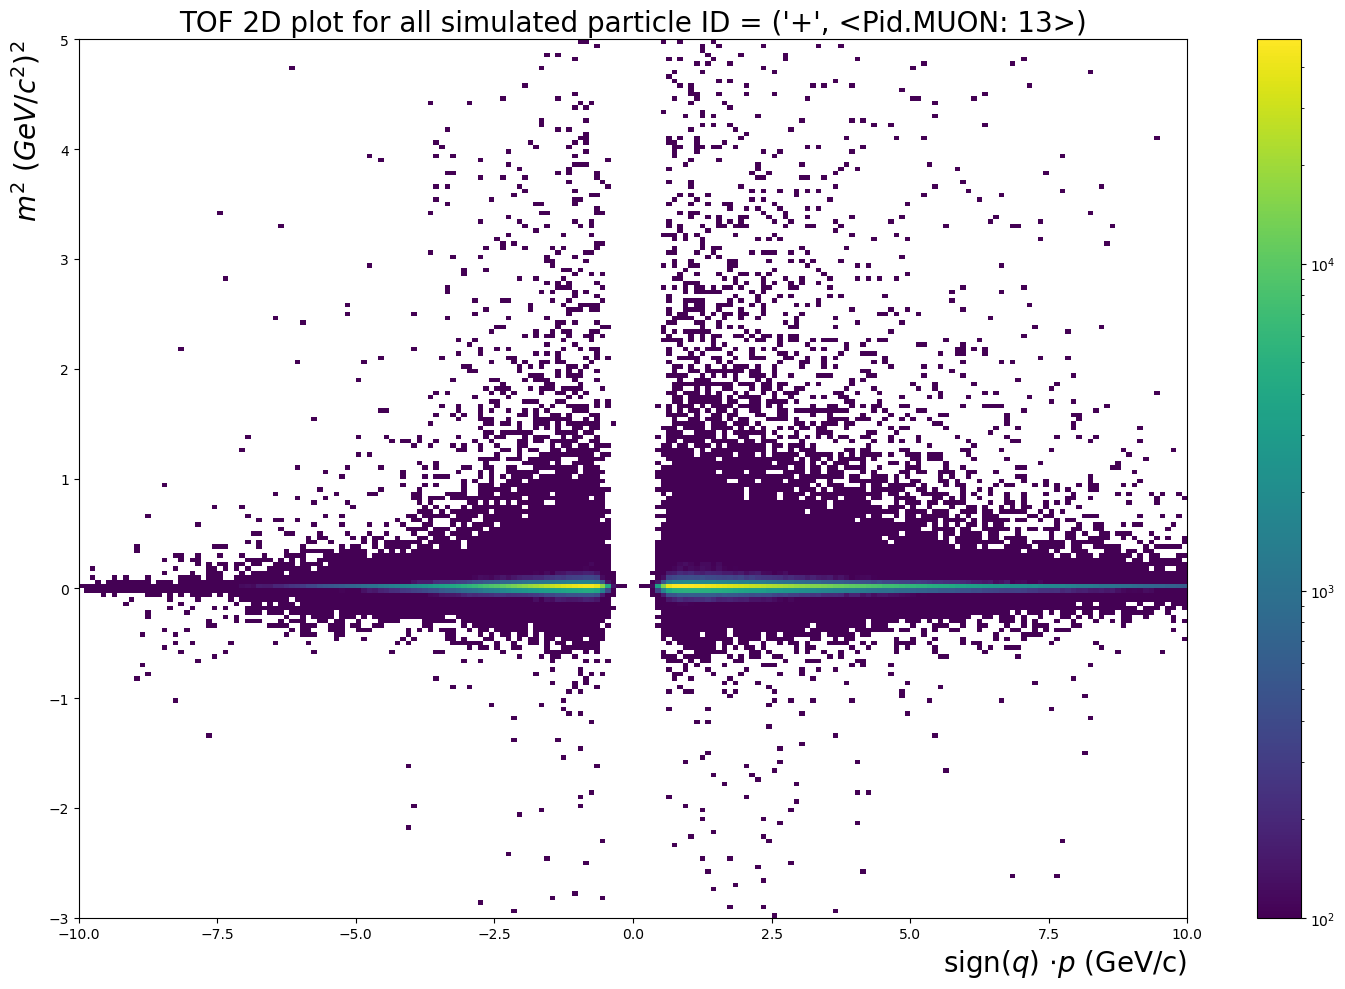

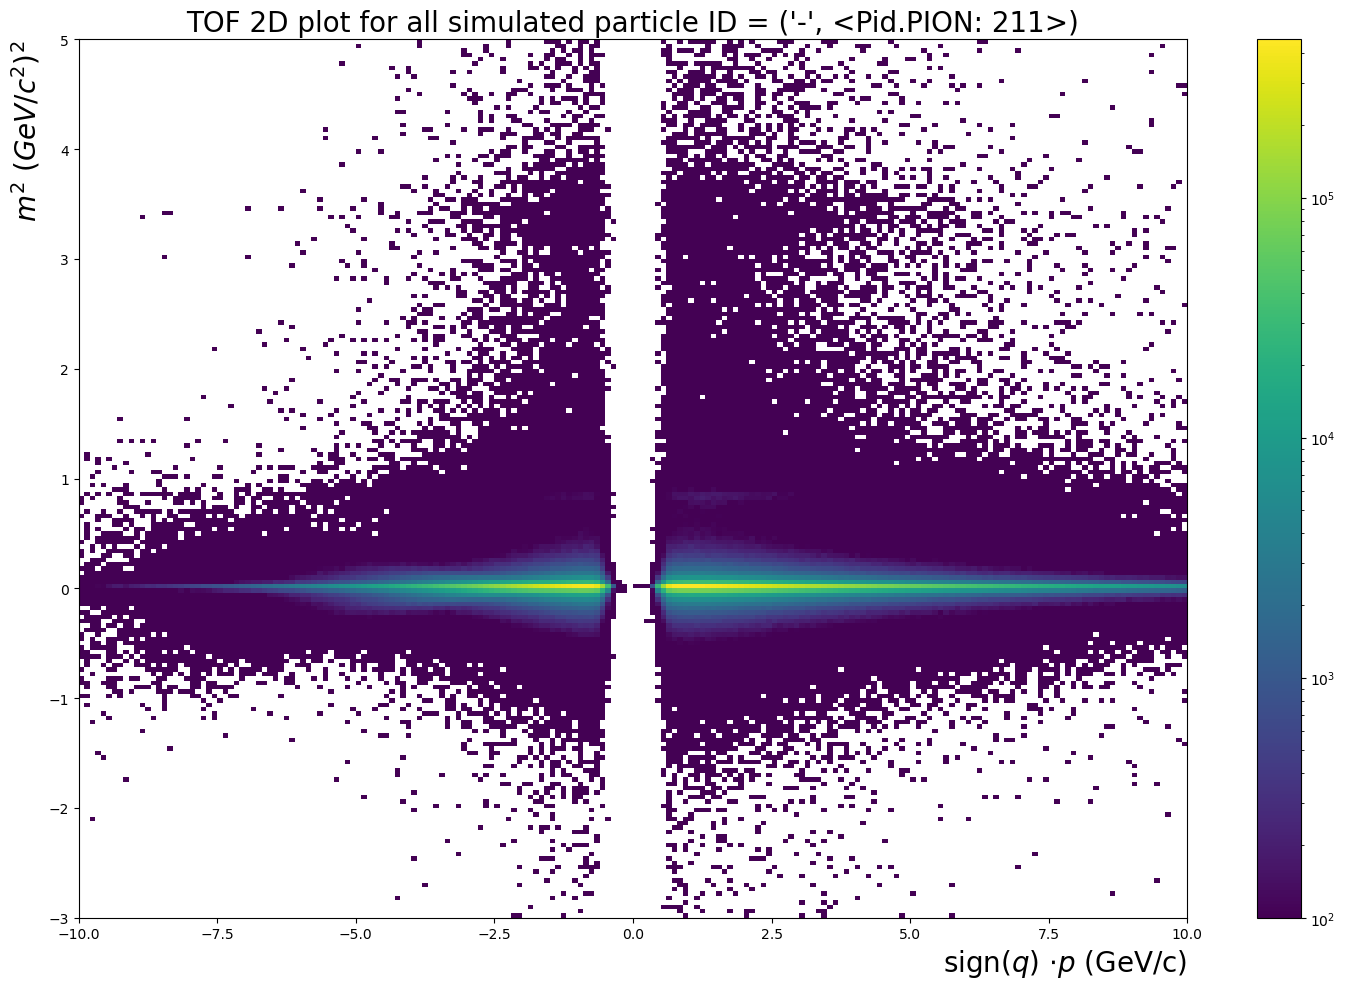

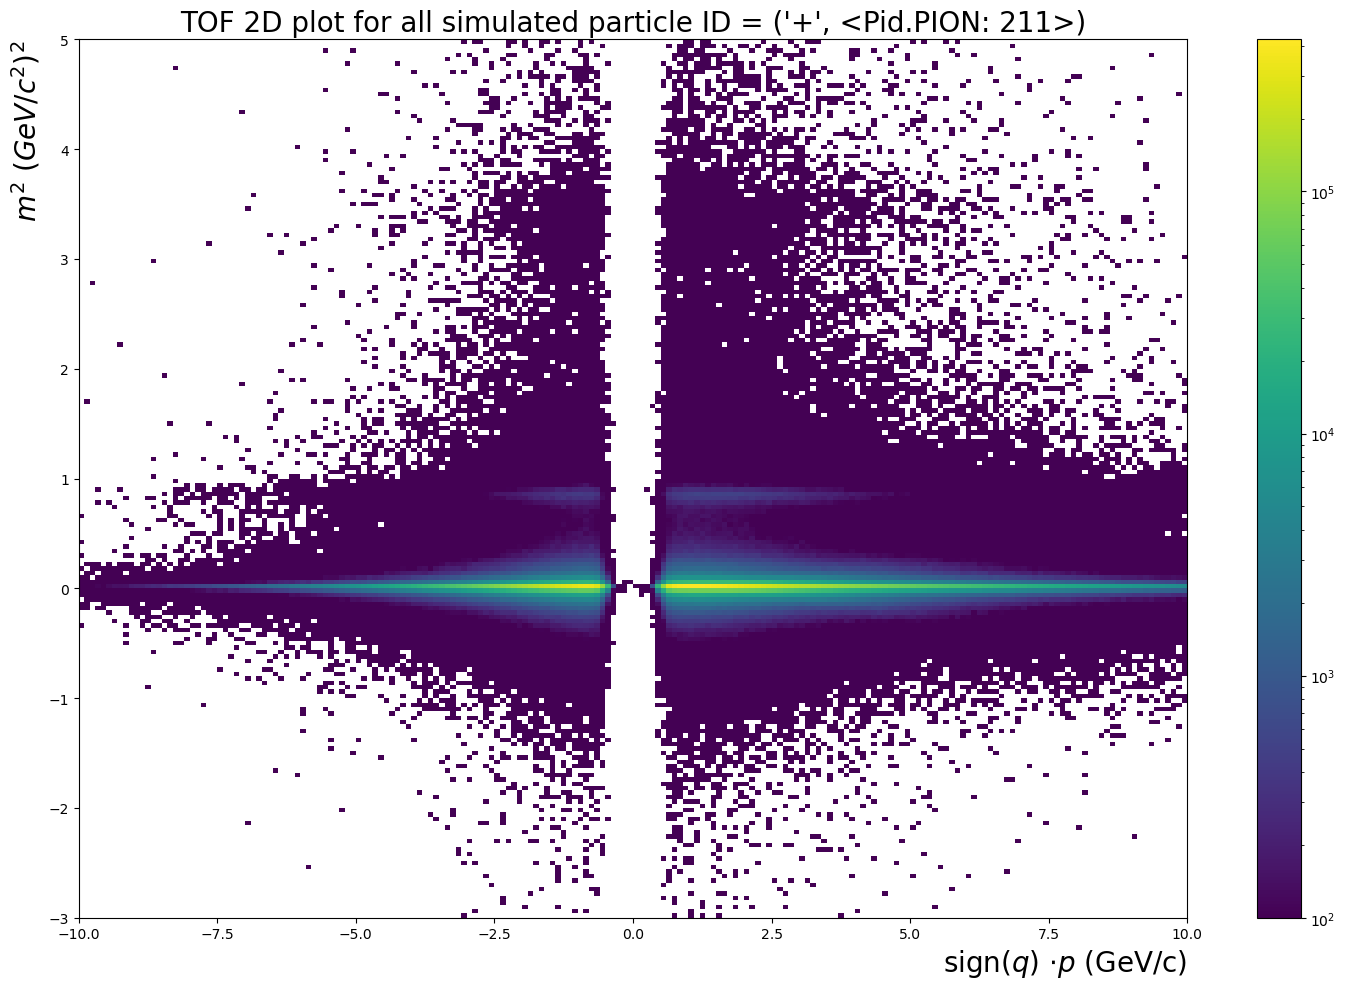

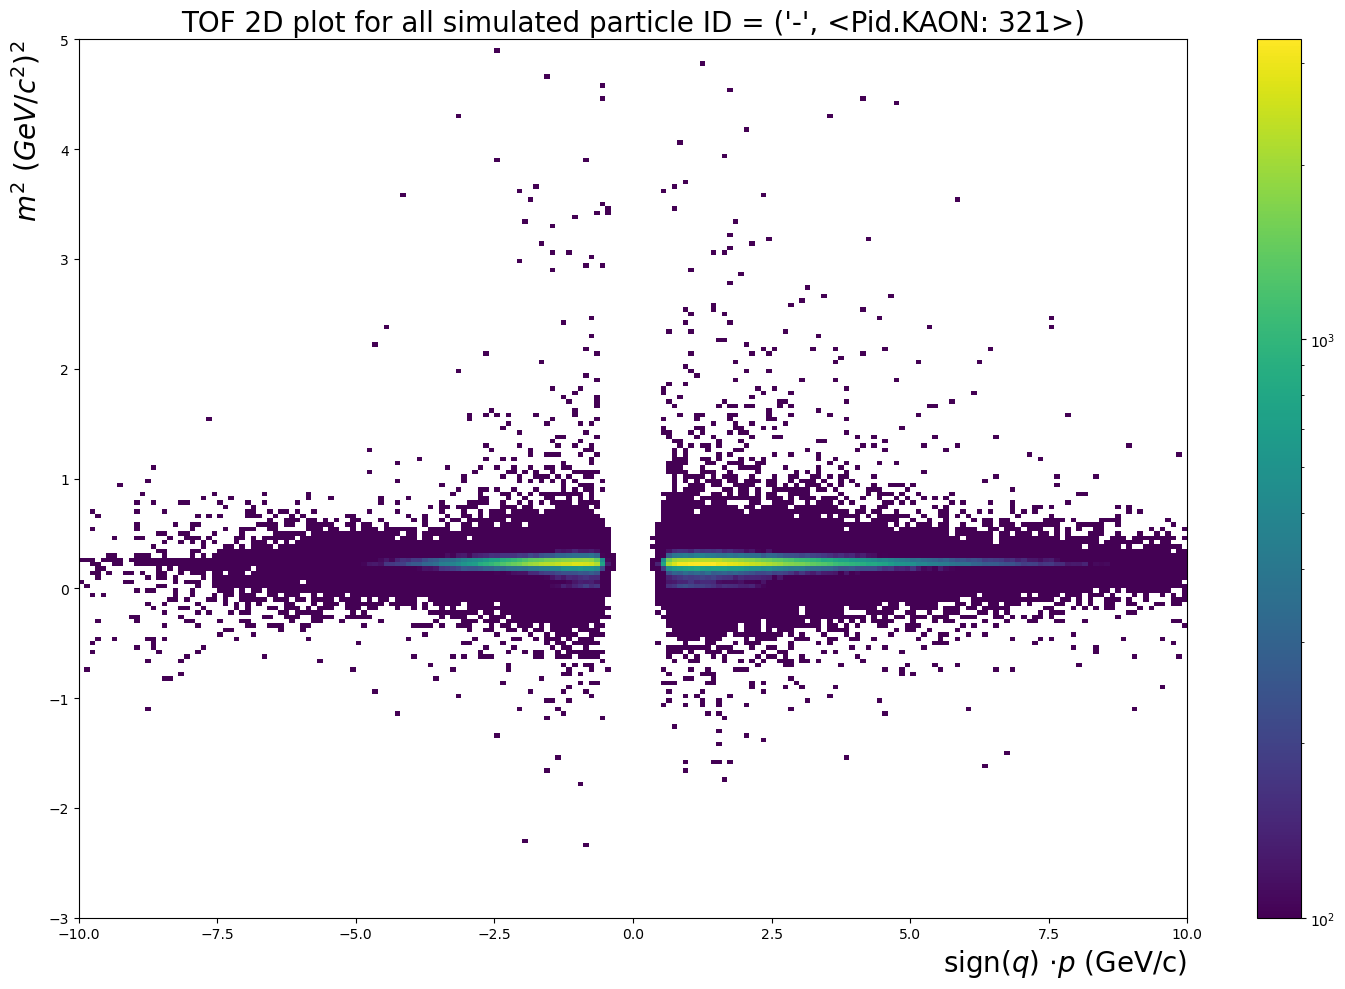

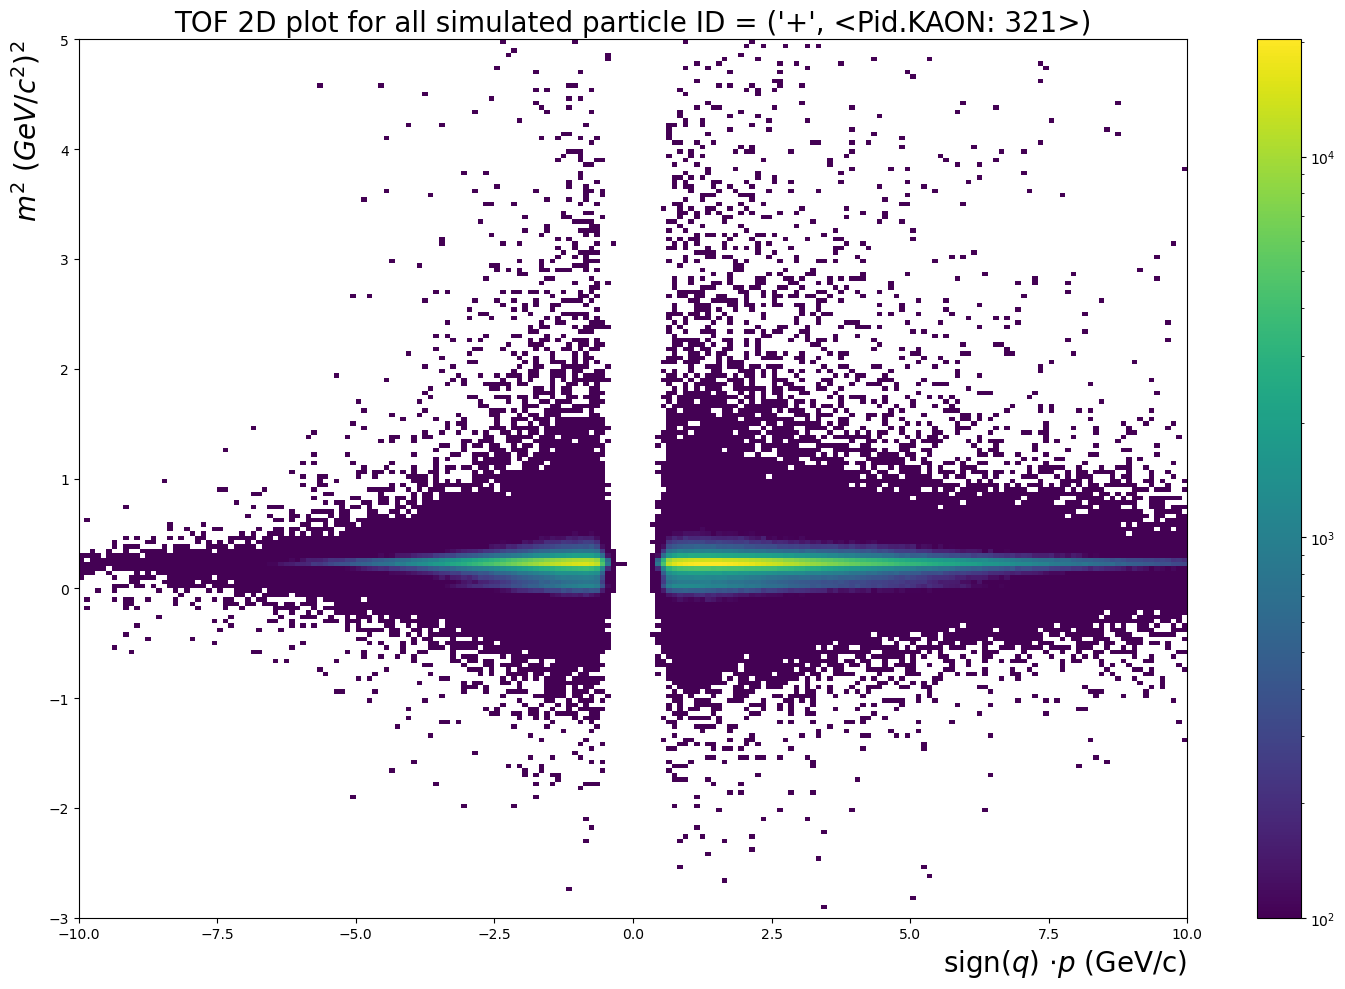

In [10]:
def classes_tof(df, pid, name, antip = 0):
    if antip == 0:
        df['pid'] = df['pid'].abs()
    part = df[df['pid']==pid]
    qp = part['q']*part['p']
    var_xaxis = qp
    mass2 = part['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-3, 5]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(vmin=100), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(name)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')
for pid in Pid:
    if pid != Pid.BCKGR:
        classes_tof(particles, -pid.value, ('-', pid), 1)
        classes_tof(particles, pid.value,  ('+', pid), 1)
        # classes_tof(particles, pid.value, pid)
        
# classes_tof(particles, -11,  'pid', 1)  

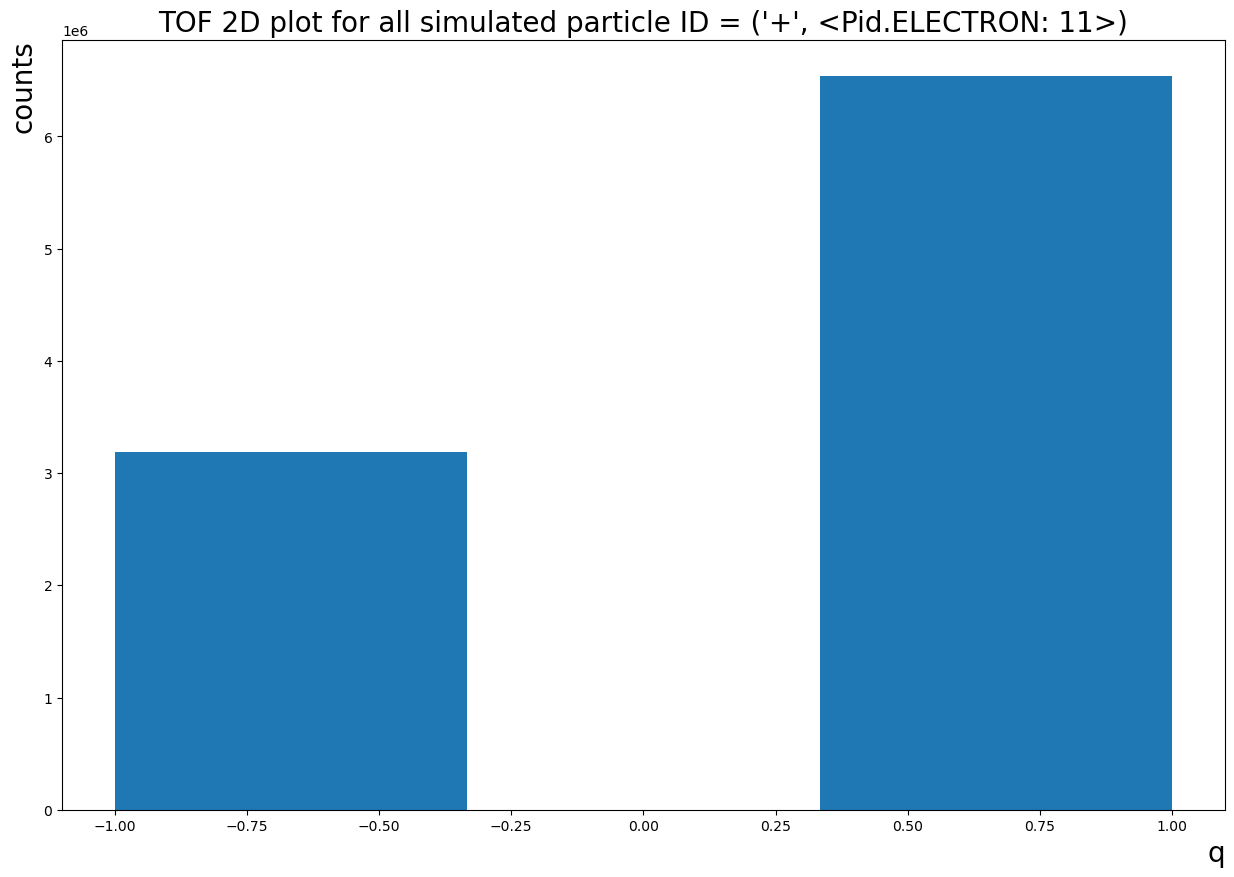

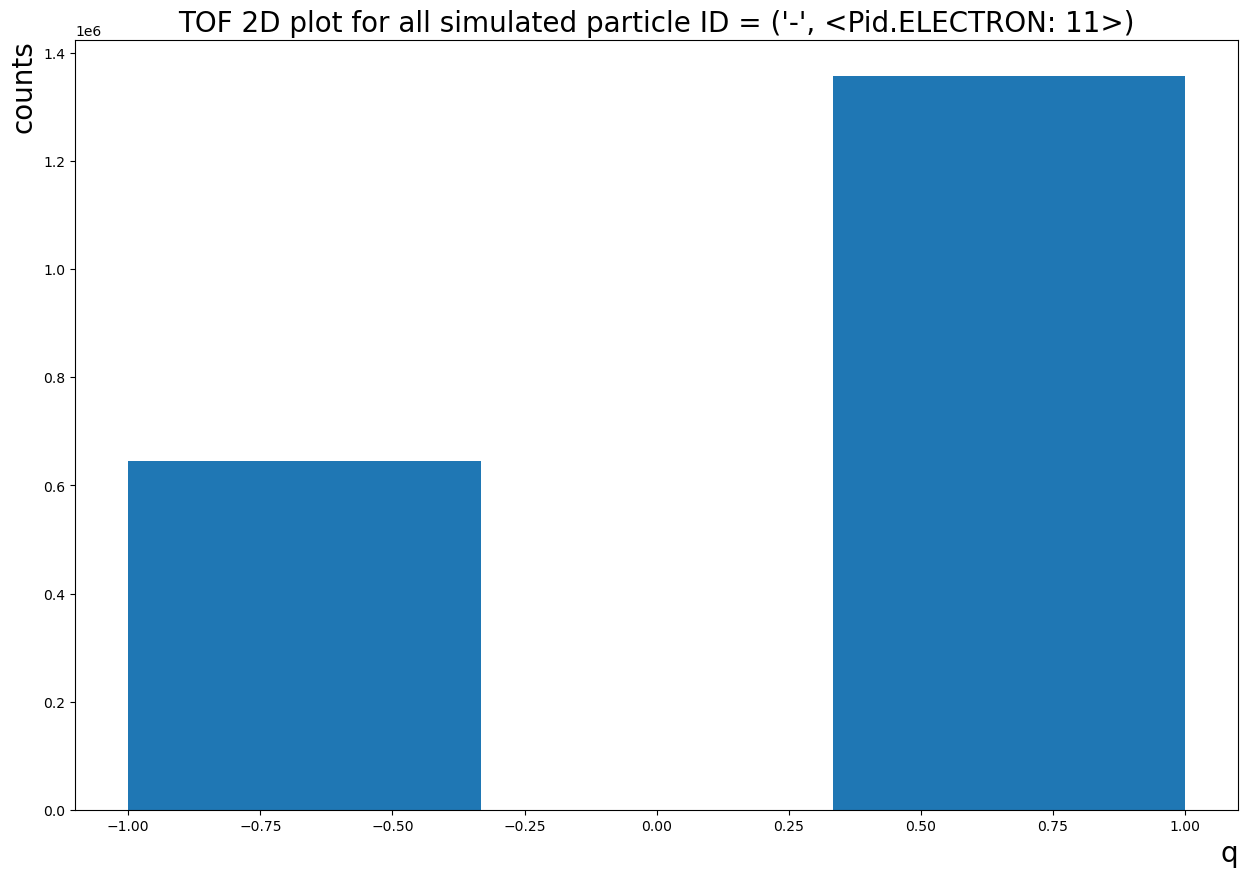

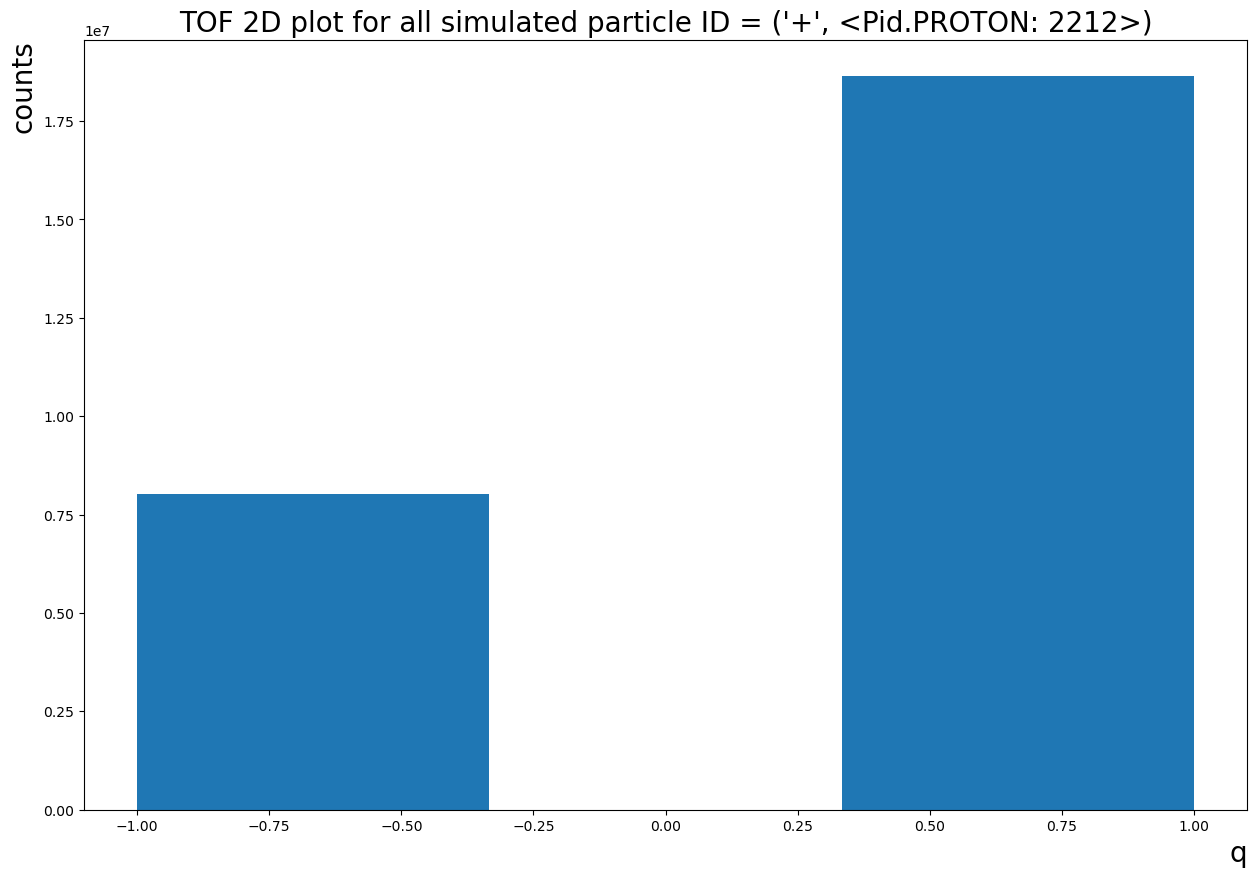

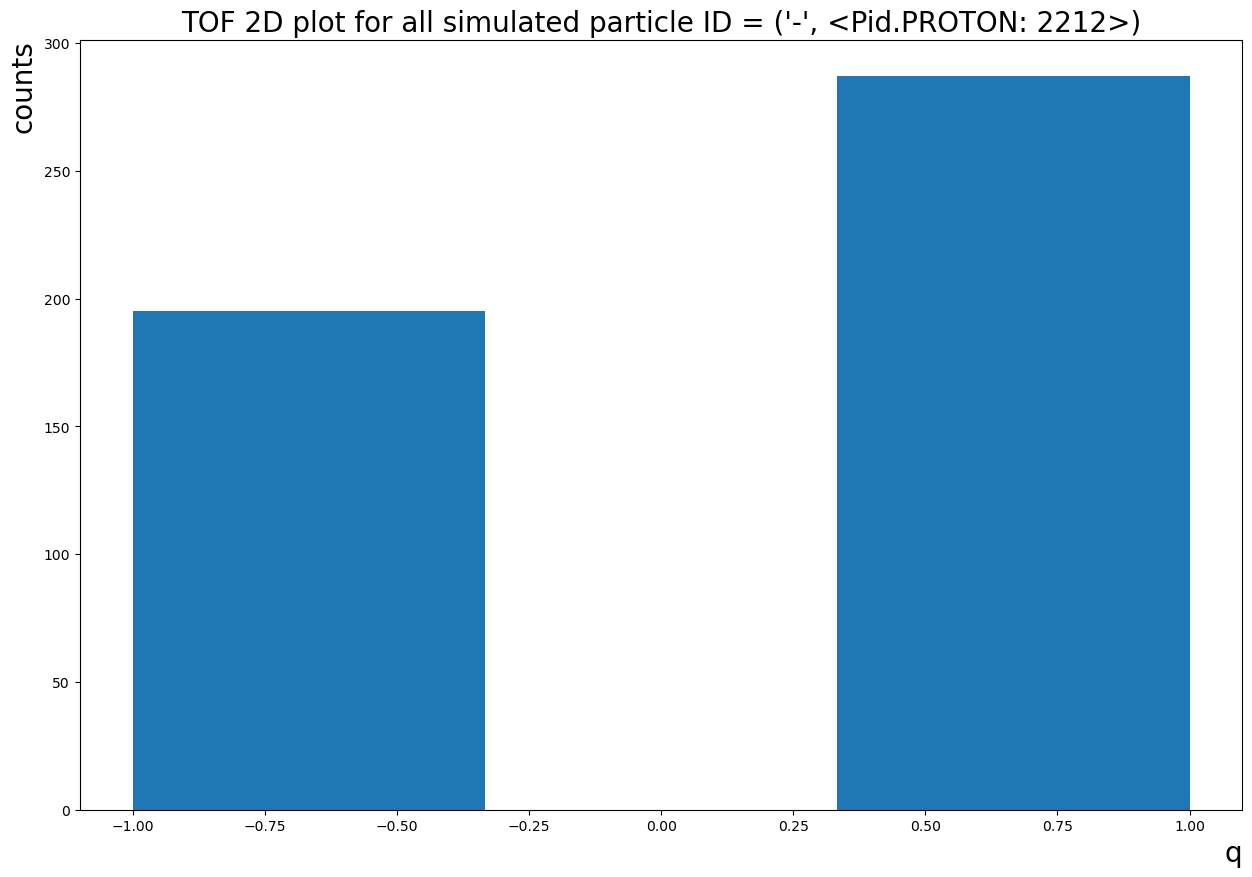

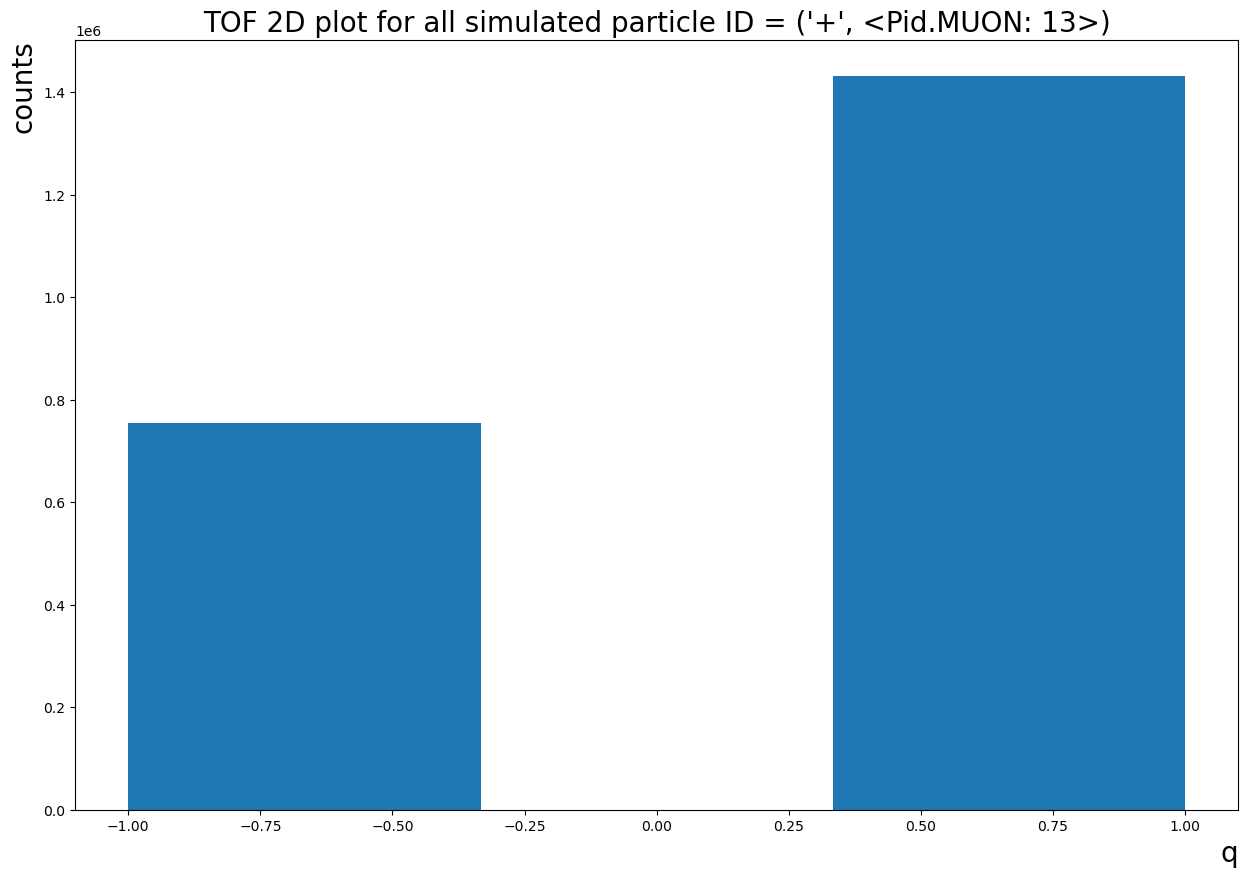

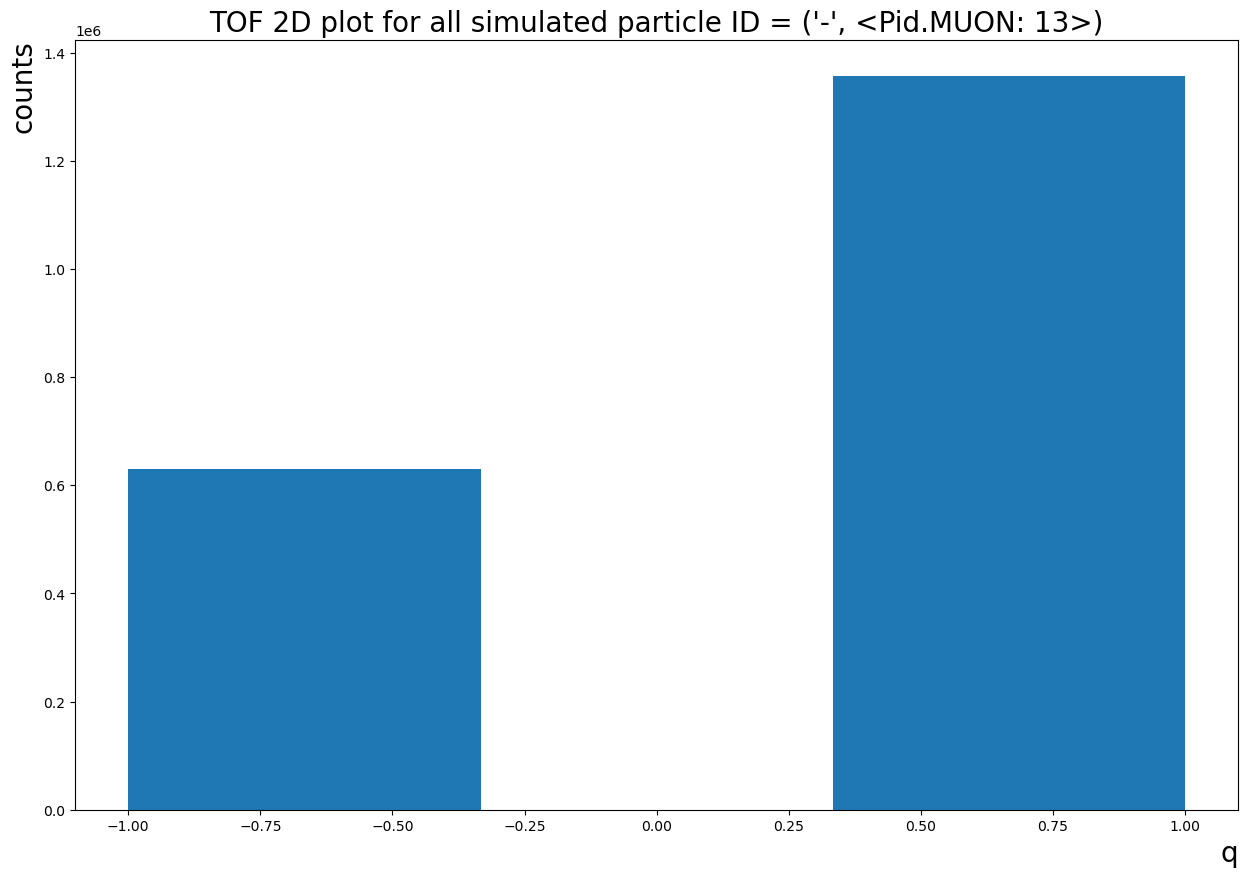

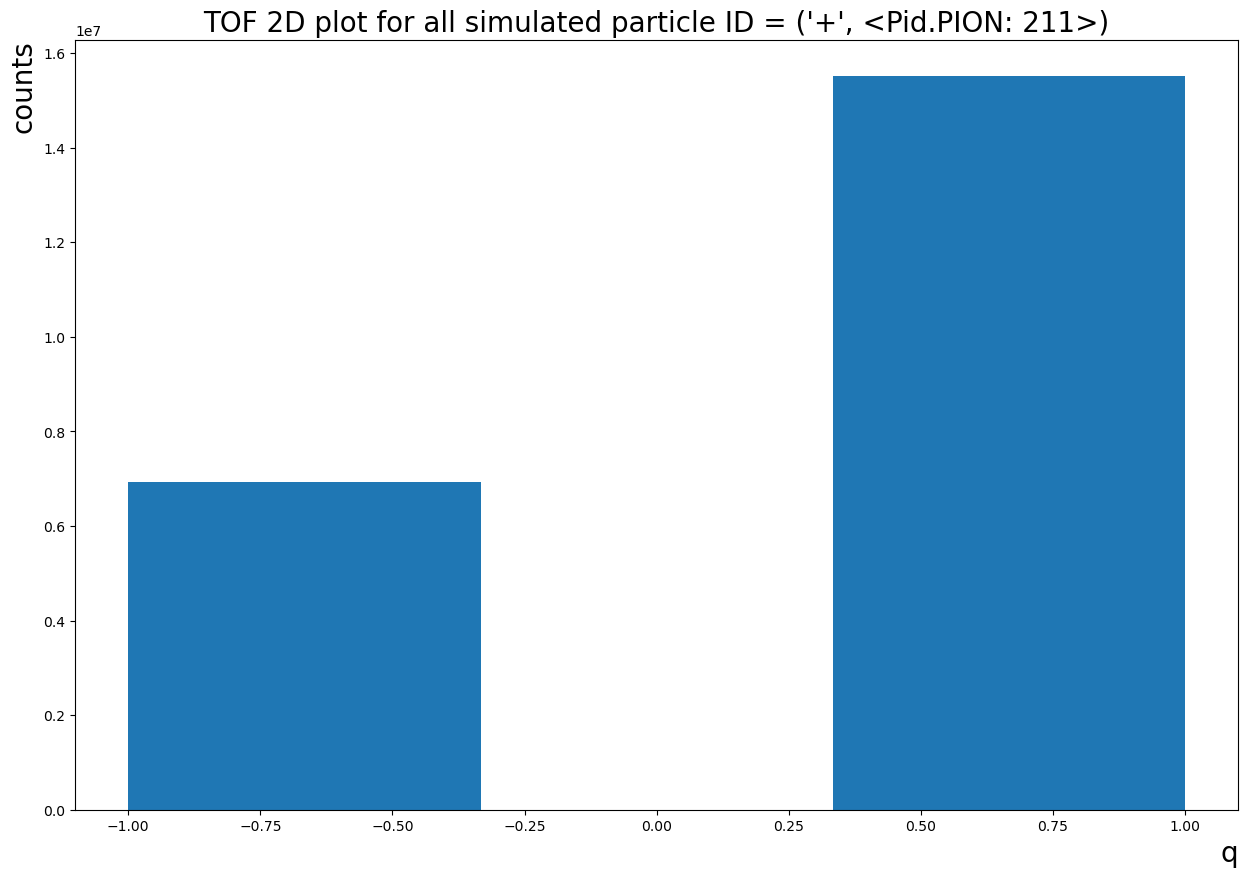

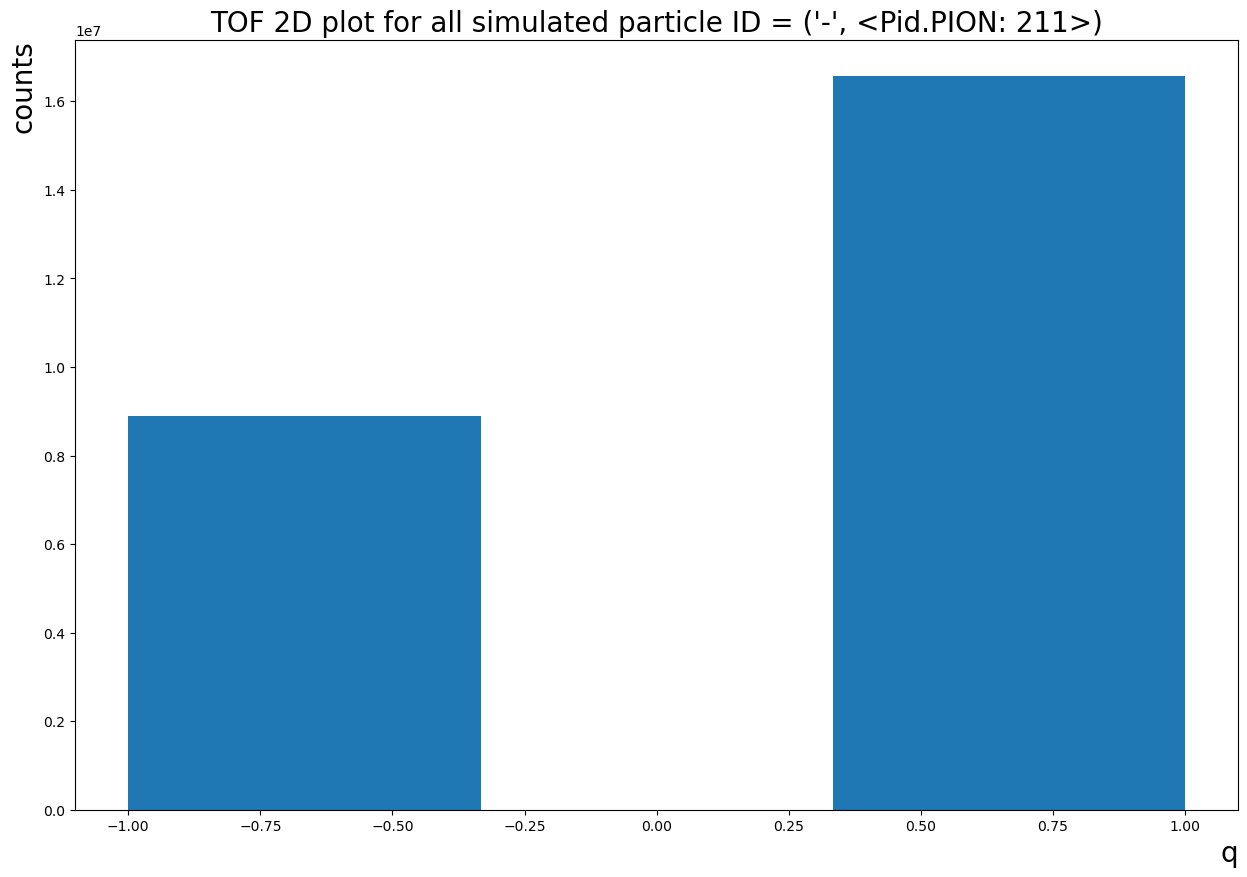

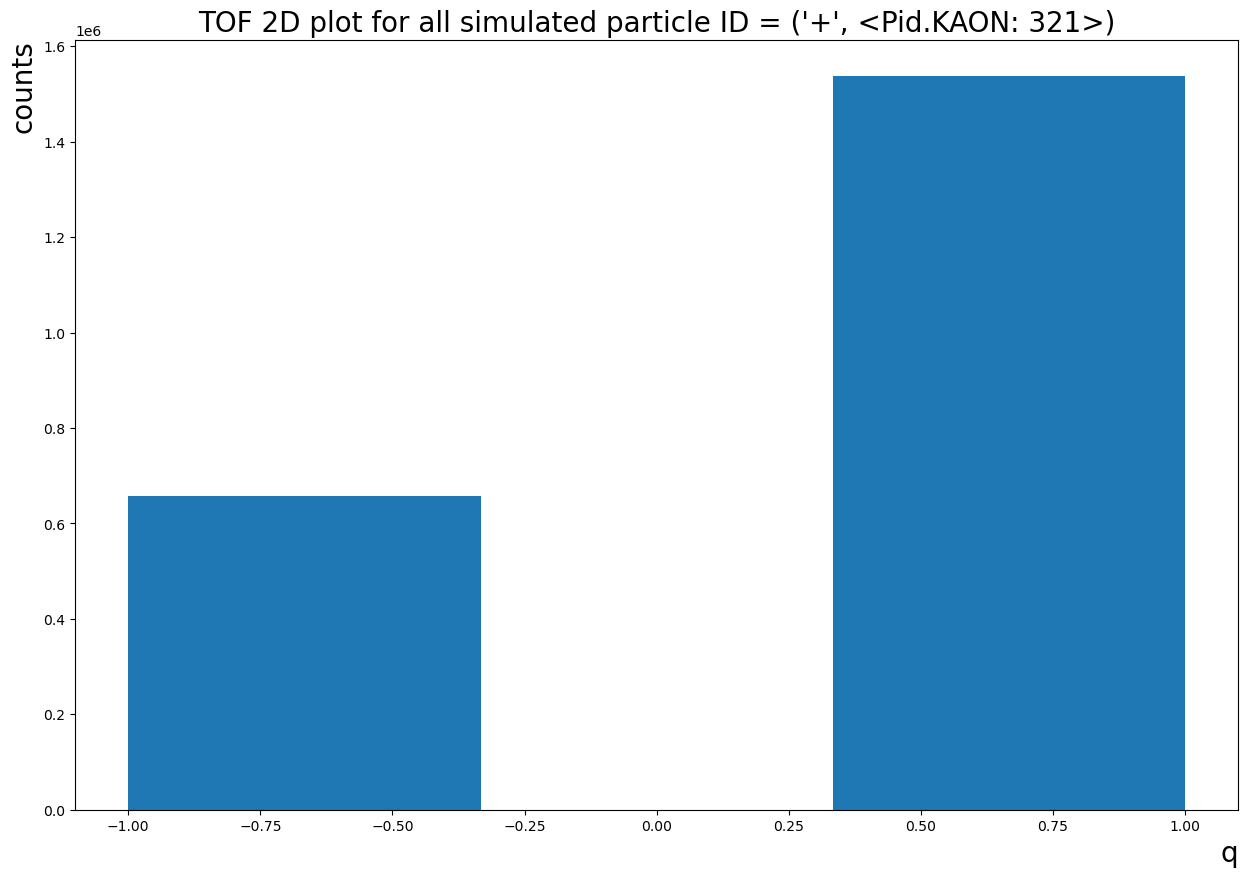

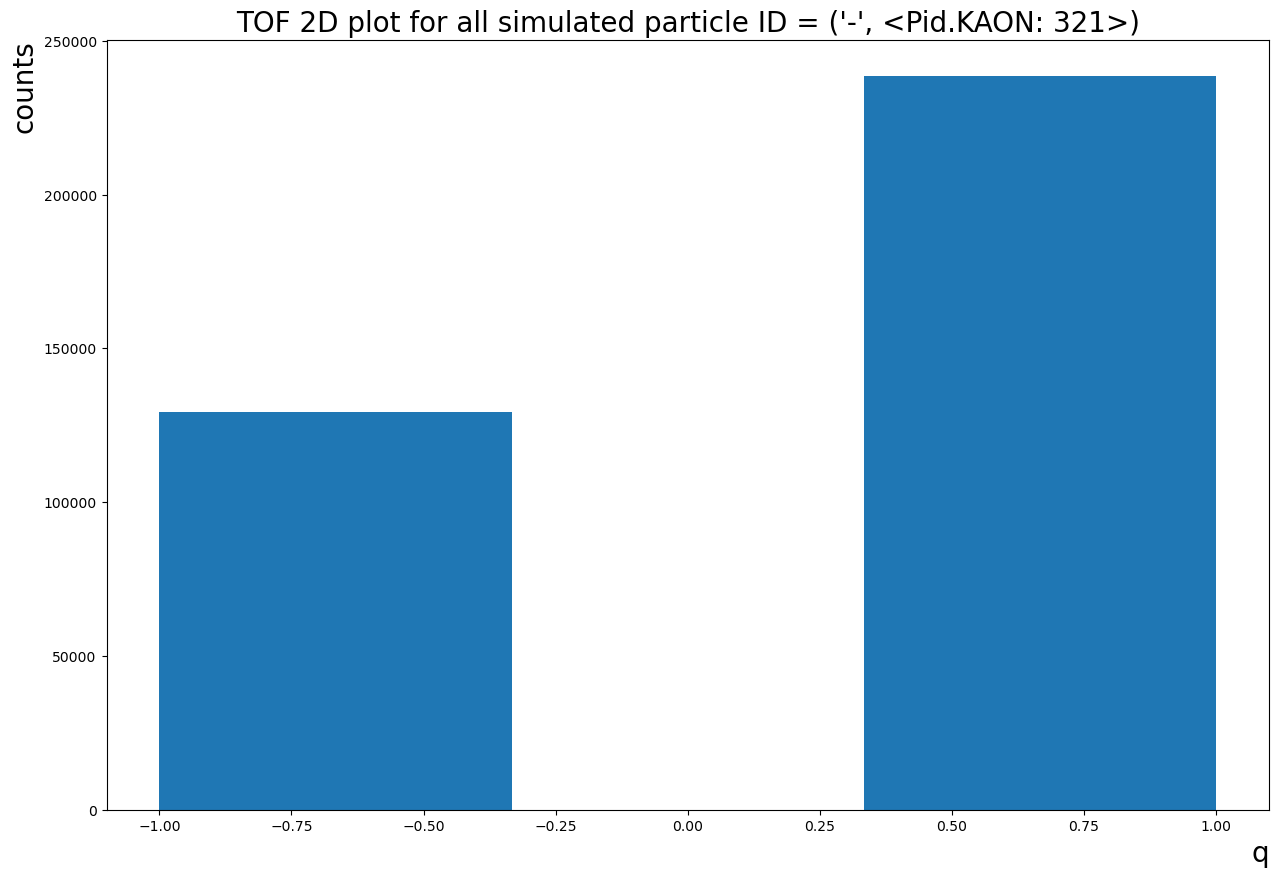

In [11]:
def q(pid, name):
    fig, axs = plt.subplots(figsize=(15, 10))
    q = particles[particles['pid']==pid]['q']
    axs.hist(q, bins=3)
    xName = r'q'
    yName = r'counts'
    title='TOF 2D plot for all simulated particle ID = ' + str(name)
    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    plt.title(title, fontsize=20)
    plt.show()
    
for pid in Pid:
    if pid != Pid.BCKGR:
        q(pid.value, ('+', pid))
        q(-pid.value, ('-', pid))

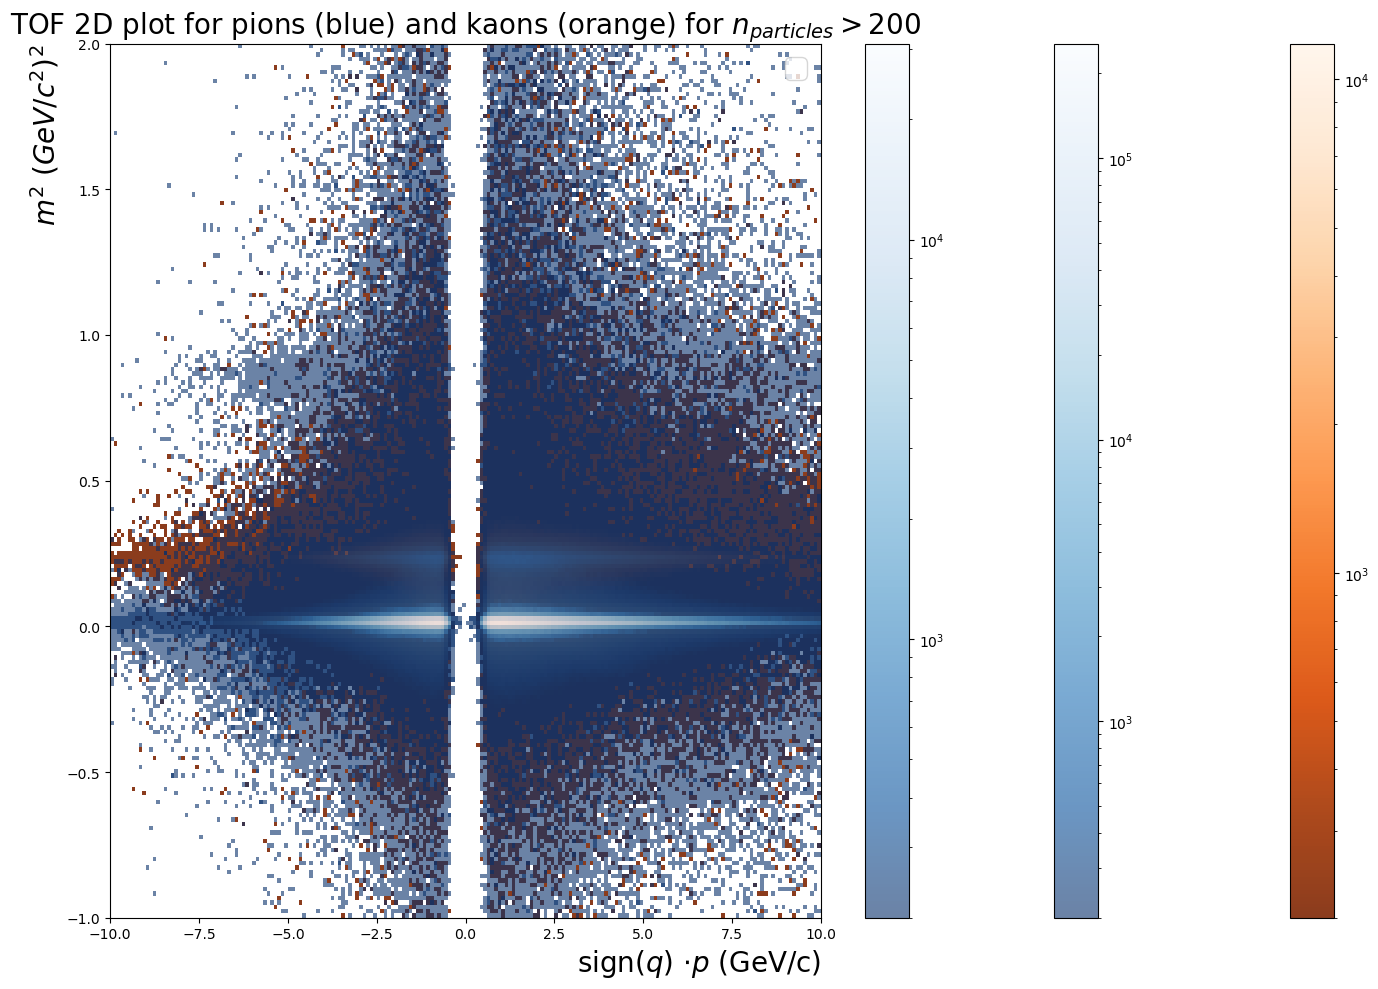

In [12]:
fig, axs = plt.subplots(figsize=(15, 10))
ranges = [[-10, 10],[-1, 2]]
xName = r'sign($q$) $\cdot p$ (GeV/c)'
yName = r'$m^2$ $(GeV/c^2)^2$'

def subplot(pid, name, color, alpha):
    qp = particles[particles['pid']==pid]['q']*particles[particles['pid']==pid]['p']
    mass2 = particles[particles['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)


subplot(Pid.KAON.value, 'kaons', 'Oranges_r', .9)
subplot(Pid.PION.value, 'pions', 'Blues_r', .6)
subplot(Pid.MUON.value, 'pions', 'Blues_r', .6) #as we use it also




plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for pions (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()

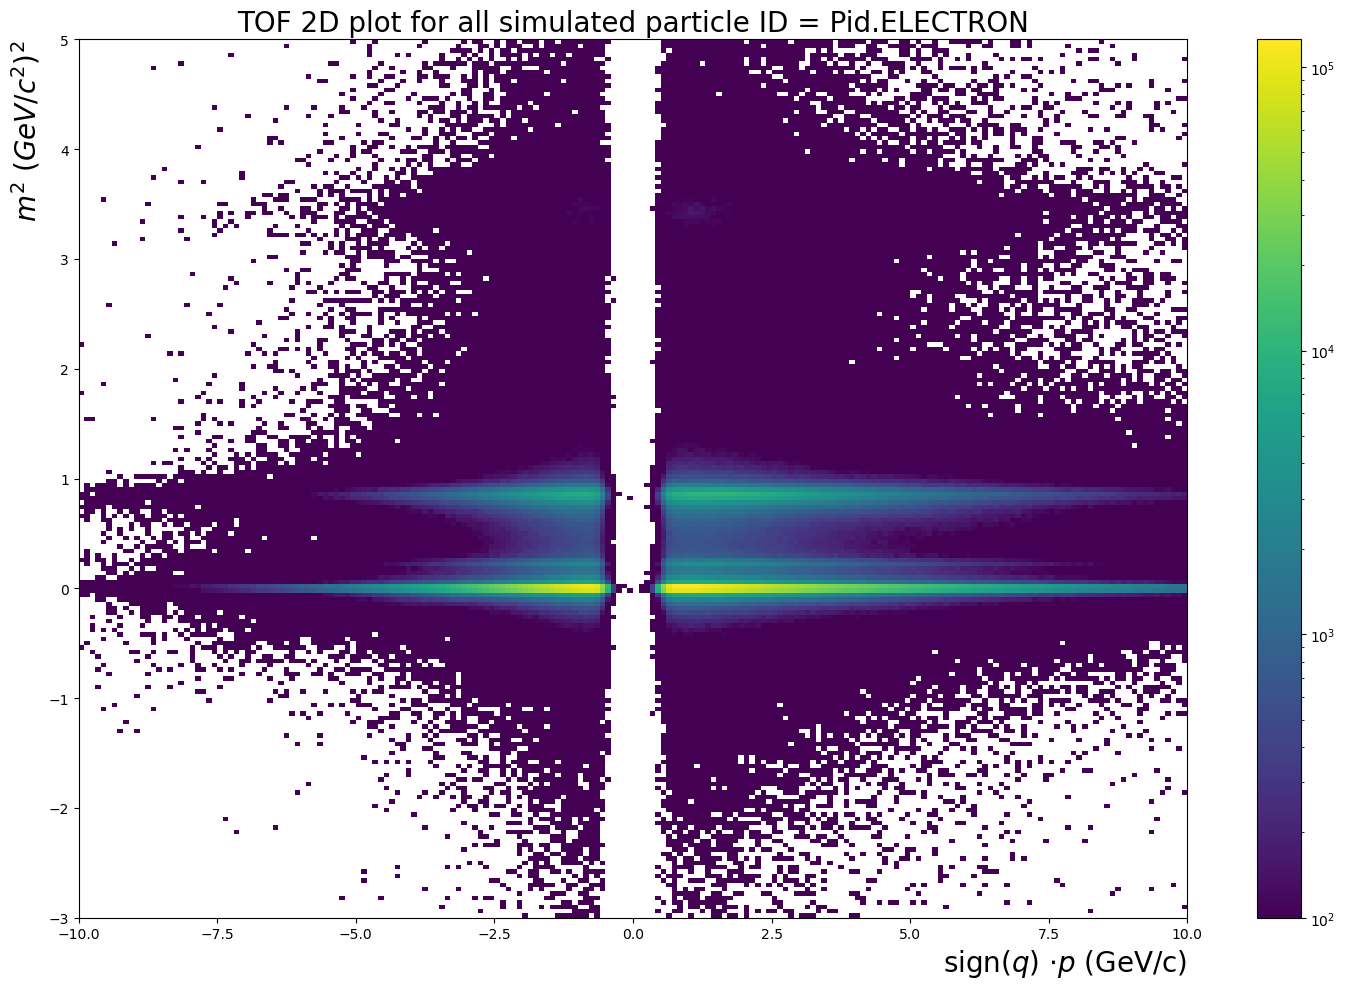

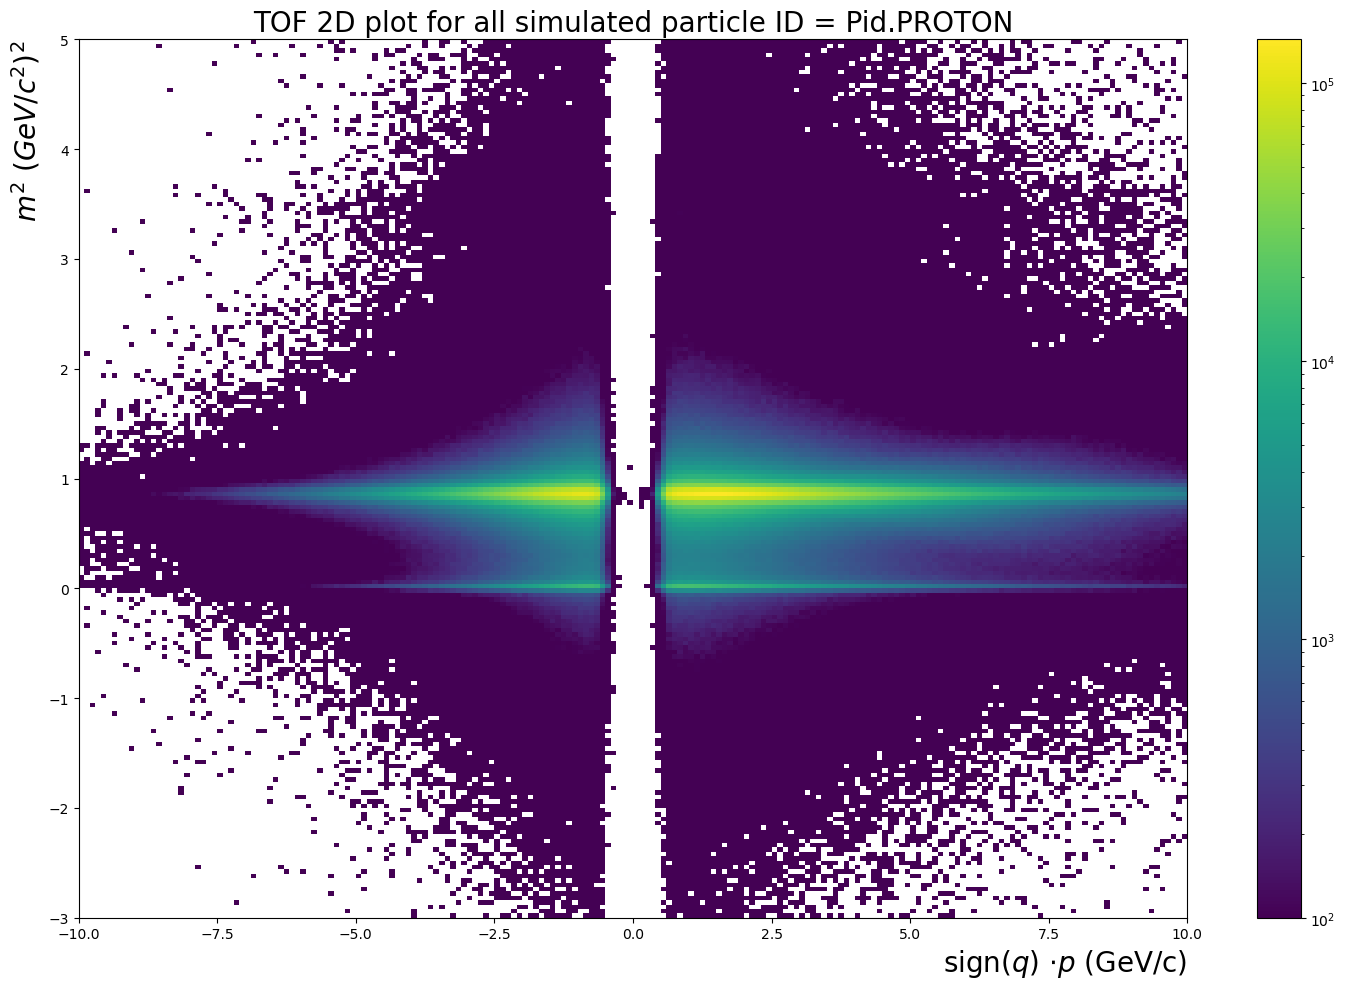

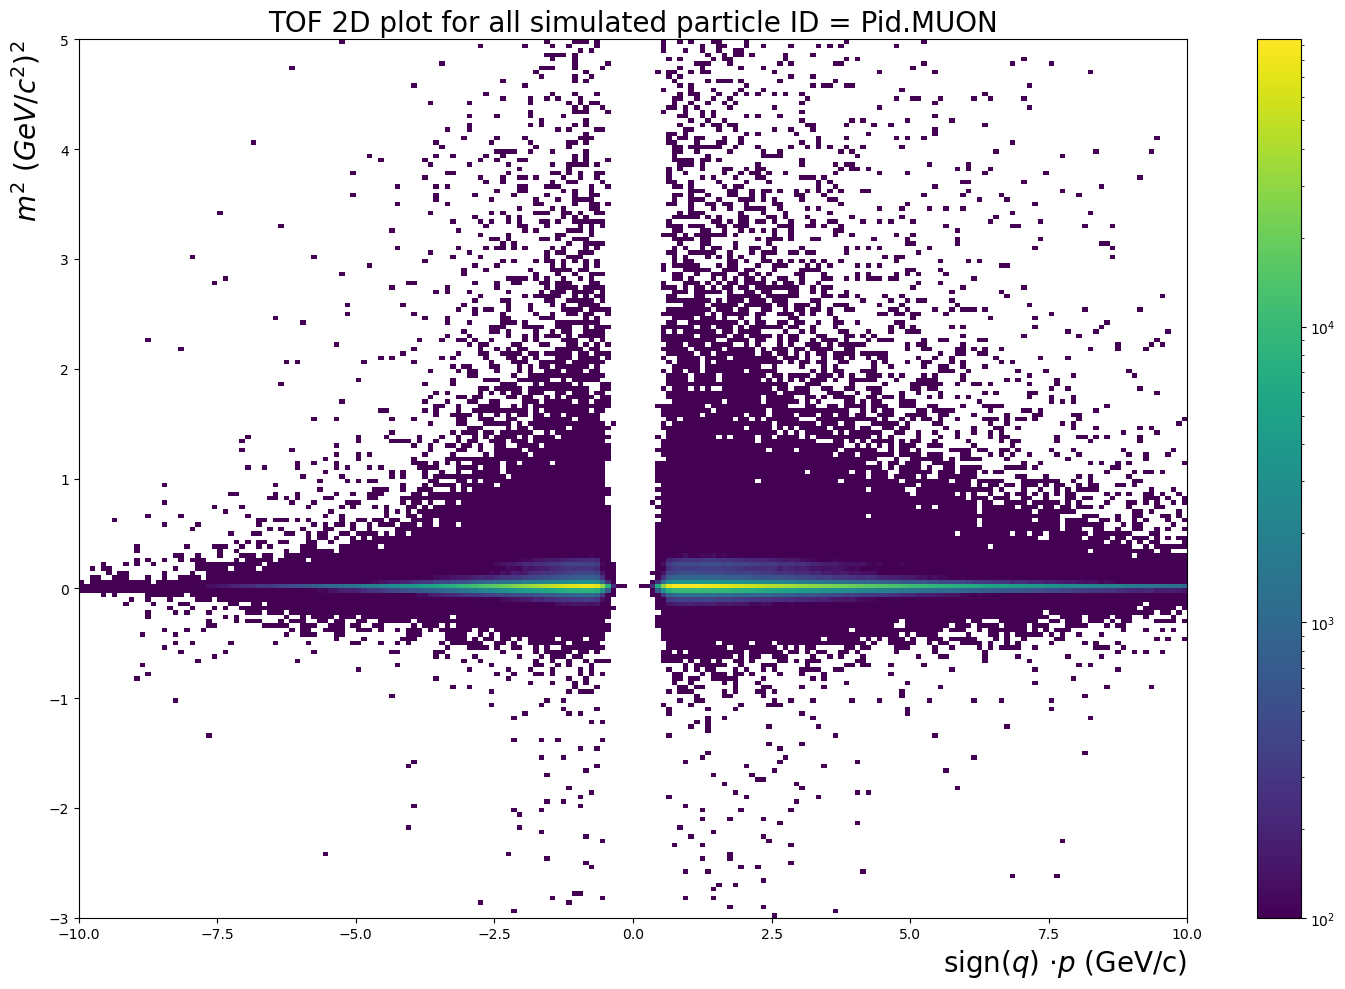

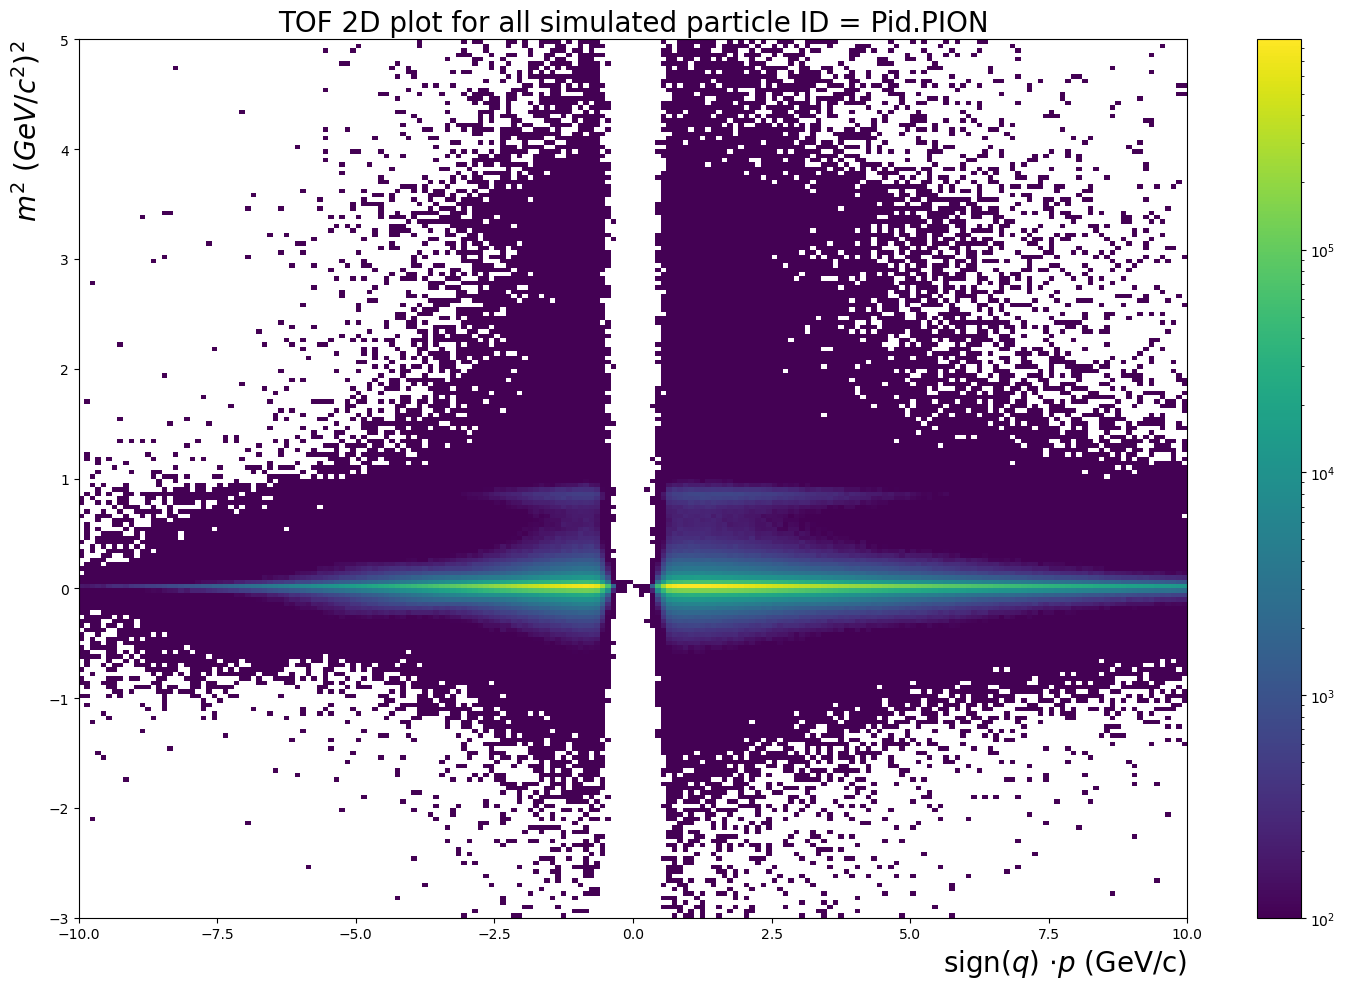

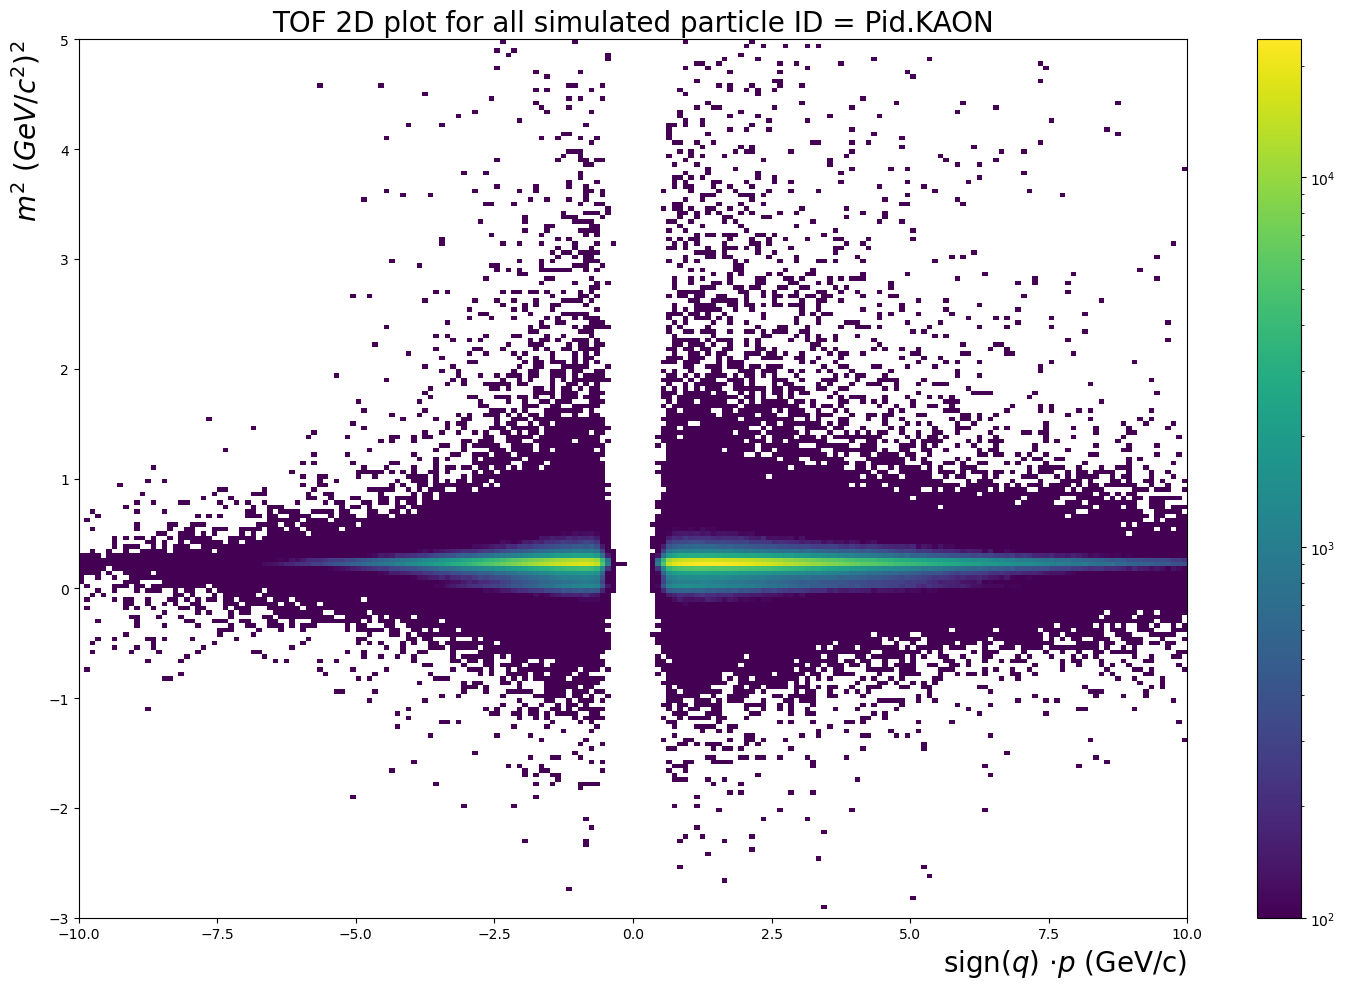

In [13]:
for pid in Pid:
    if pid != Pid.BCKGR:
        classes_tof(particles, pid.value, pid)

After 1 sigma selection

In [14]:

particles['pid'] = remap_names(particles)
#dropping bckgr value for training
particles = particles[particles['pid'] != 3]
gc.collect()
print('number of particles before downsampling : ' + str(len(particles)))

#downsampling the data

particles = downsample(particles, 'pid')
print('number of particles per class after downsampling : ' + str(len(particles)/3))
particles.iloc[0:10,:]
#cleaning and 1sigma region selection
# particles = clean_df(particles)
# for particle in particles['pid'].unique(): 
#     particles = sigma(particles, particle, 1, True)

number of particles before downsampling : 81285272
number of particles per class after downsampling : 2561563.0


,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,2.521118,0.938272,0.936620,2.674792,0.427185,-0.976415,0.239222,-0.353920,2.640459,1.669727,0,1.0
1,2.021178,0.938272,1.018730,0.801026,0.208608,1.509832,0.012710,0.208221,0.773385,0.736271,0,1.0
2,2.049591,0.938272,0.817333,1.010622,0.256064,1.799634,-0.058087,0.249388,0.977644,0.885046,0,1.0
3,2.209019,0.938272,0.051896,3.211388,0.696872,0.590031,0.579047,0.387730,3.134866,1.712862,0,1.0
4,2.456533,0.938272,0.914826,2.340321,0.398351,0.351144,0.374044,0.137022,2.306170,1.555195,0,1.0
5,1.482129,0.938272,1.003918,0.591941,0.255728,2.457799,-0.198236,0.161553,0.533852,0.524560,0,1.0
6,2.472669,0.938272,0.824374,2.974236,0.498263,-0.437264,0.451384,-0.210996,2.932203,1.739713,0,1.0
7,2.837318,0.938272,0.354049,2.974779,0.347349,-1.425640,0.050243,-0.343696,2.954430,1.803461,0,1.0
8,2.583789,0.938272,0.895858,2.510013,0.376802,2.473697,-0.295838,0.233367,2.481569,1.630128,0,1.0
9,3.246969,0.938272,0.874580,3.716624,0.288655,1.636790,-0.019036,0.288027,3.705397,2.038539,0,-1.0


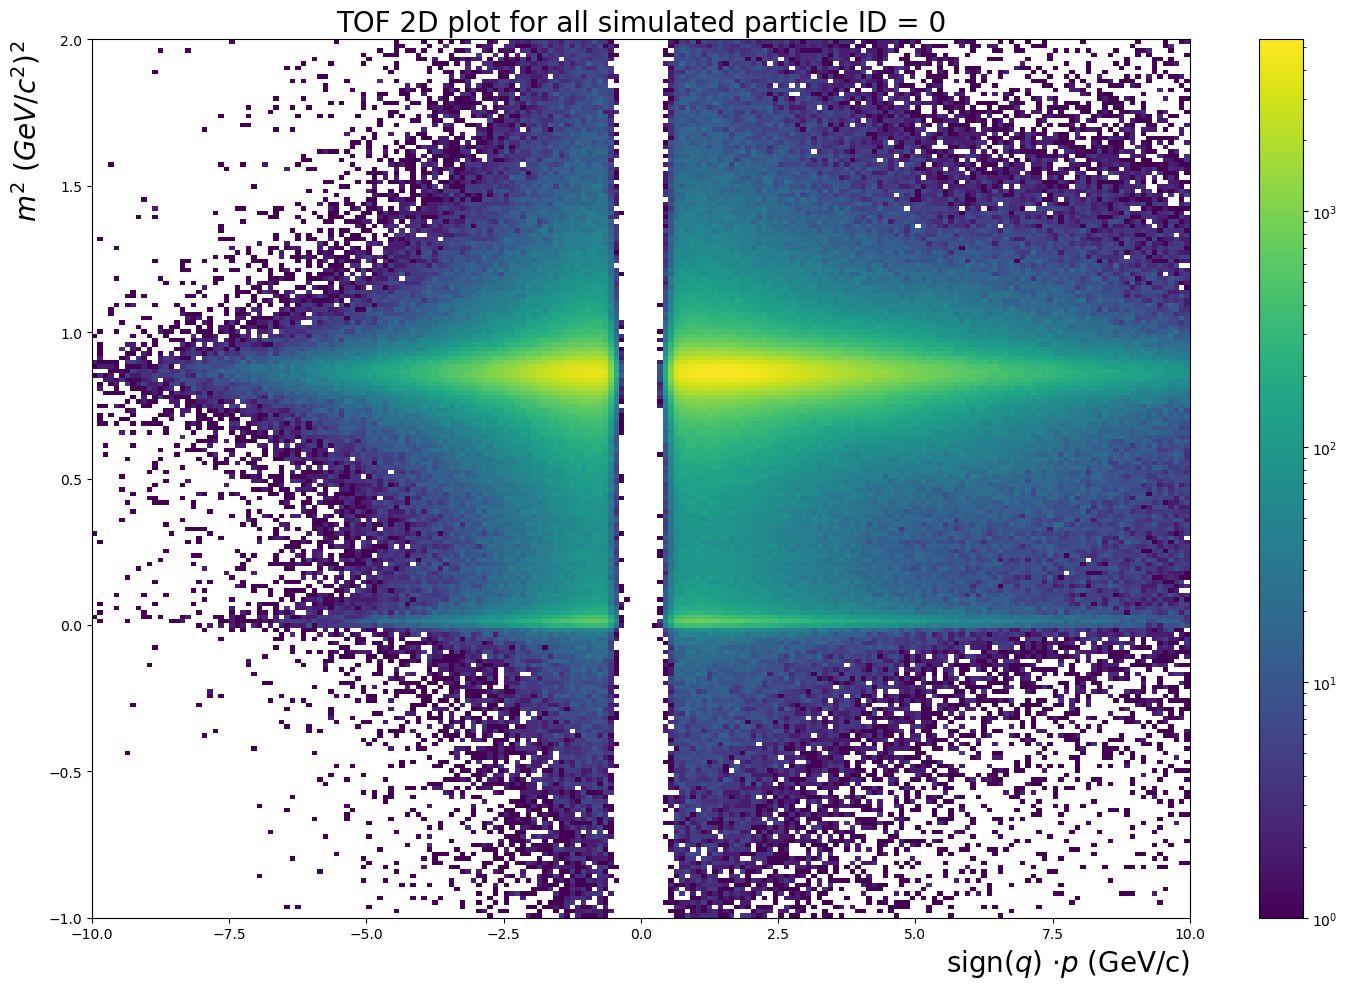

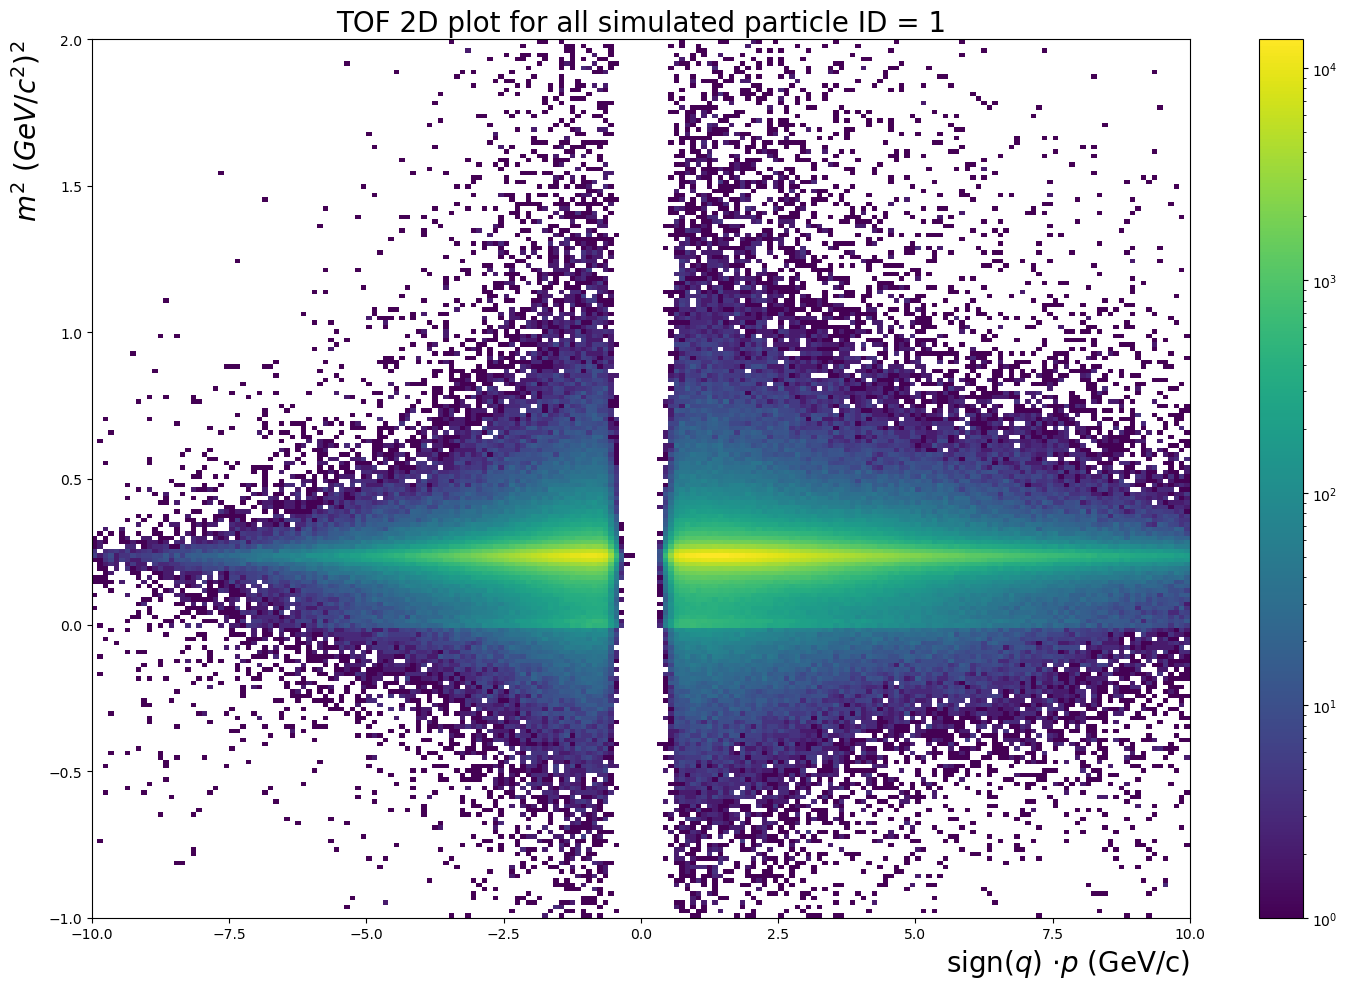

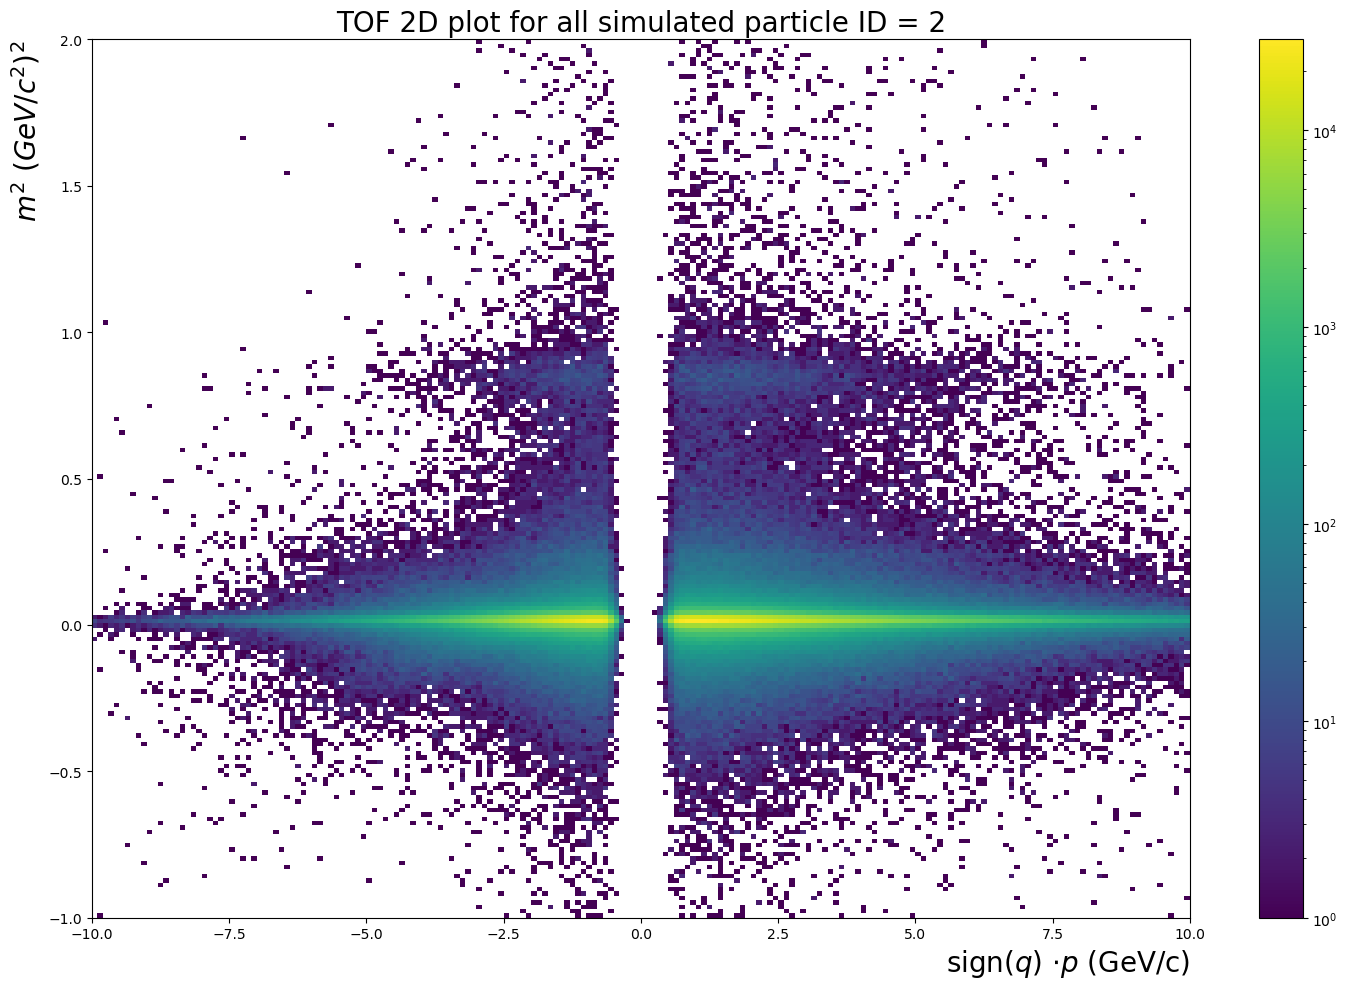

In [15]:
'''before cleaning'''
for i in range(3):
    sim_tof(particles, i)

we get rid of 5.0 % of pid = 0 particle entries
we get rid of 4.87 % of pid = 1 particle entries
we get rid of 2.42 % of pid = 2 particle entries


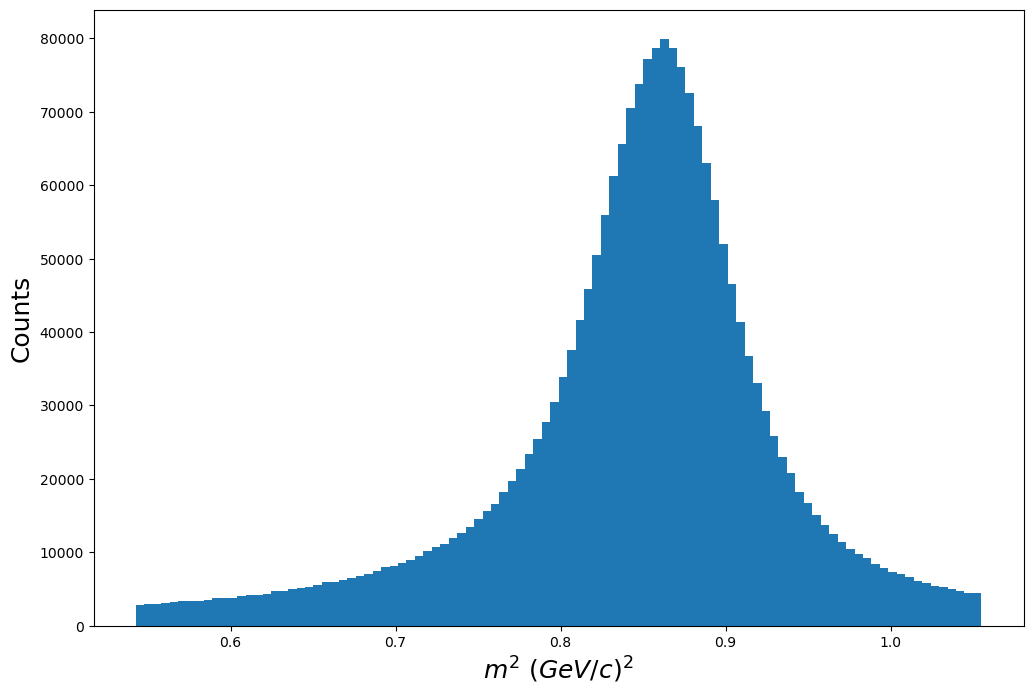

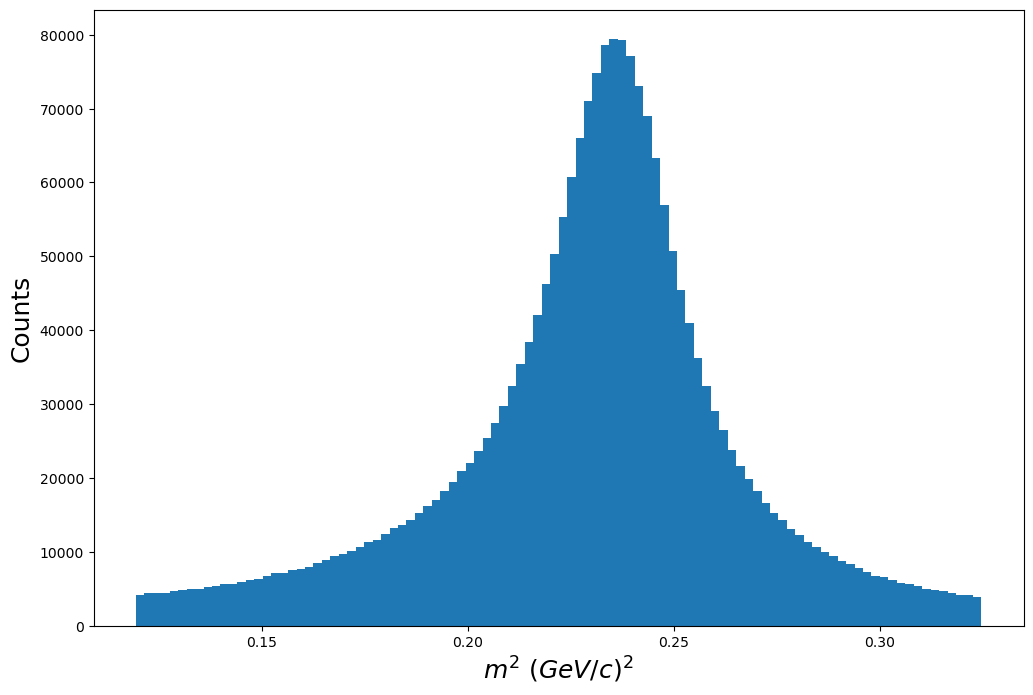

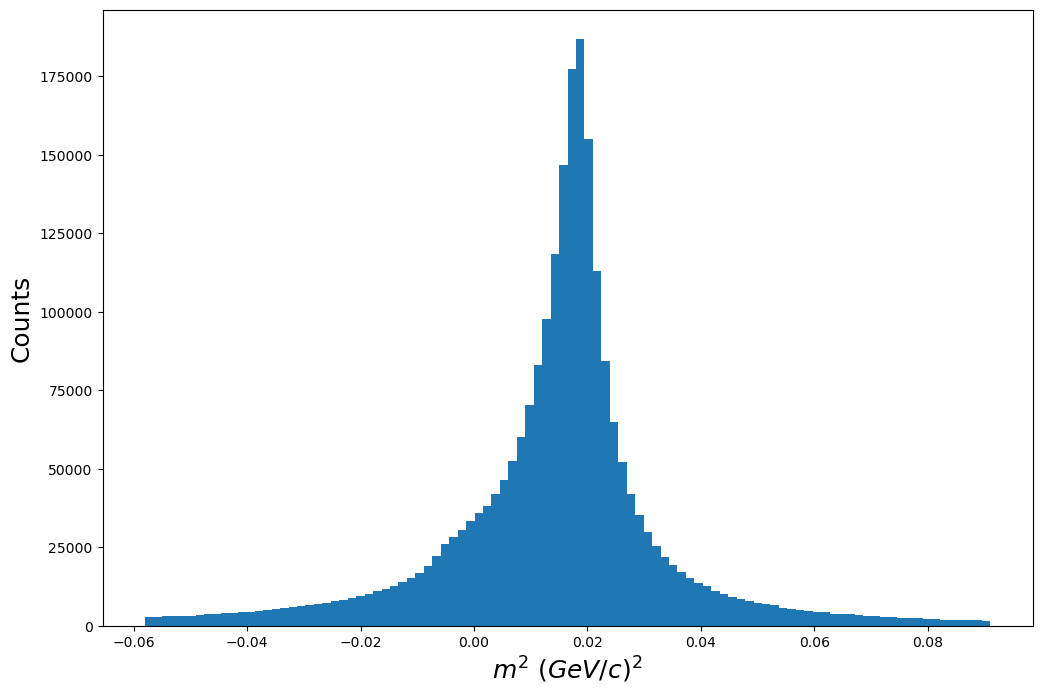

In [16]:
#cleaning and 1sigma region selection
particles = clean_df(particles)
for particle in particles['pid'].unique(): 
    particles = sigma(particles, particle, 1, True)
# we check sigma selection
for pid in particles['pid'].unique():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(particles[particles['pid'] == pid]['mass2'], bins=100)
    ax.set_xlabel('$m^2$ $(GeV/c)^2$',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    # ax.set_yscale('log')
    
    plt.show()

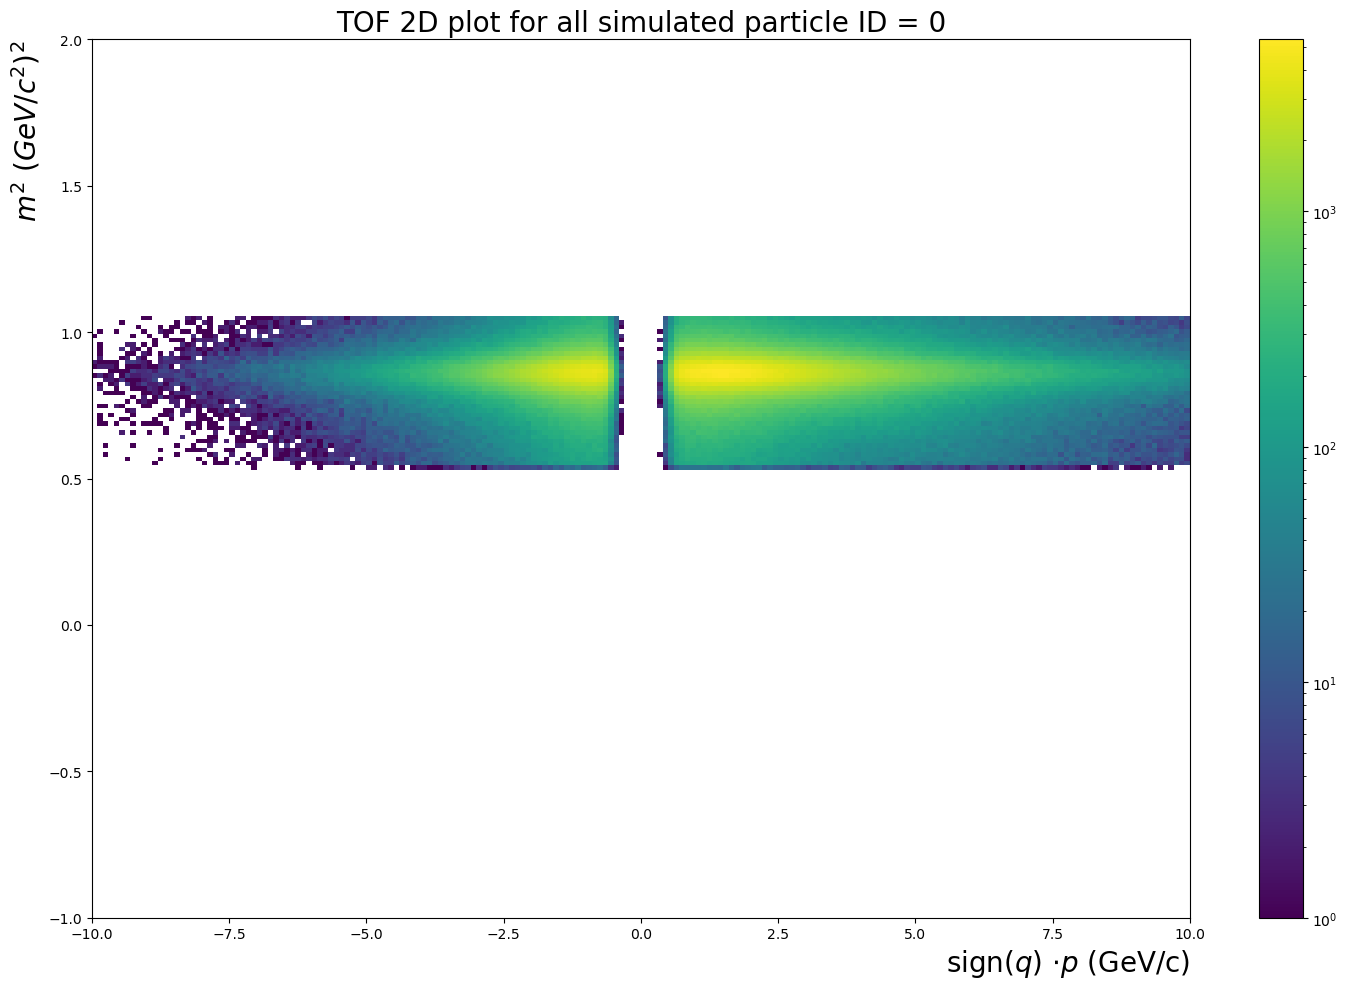

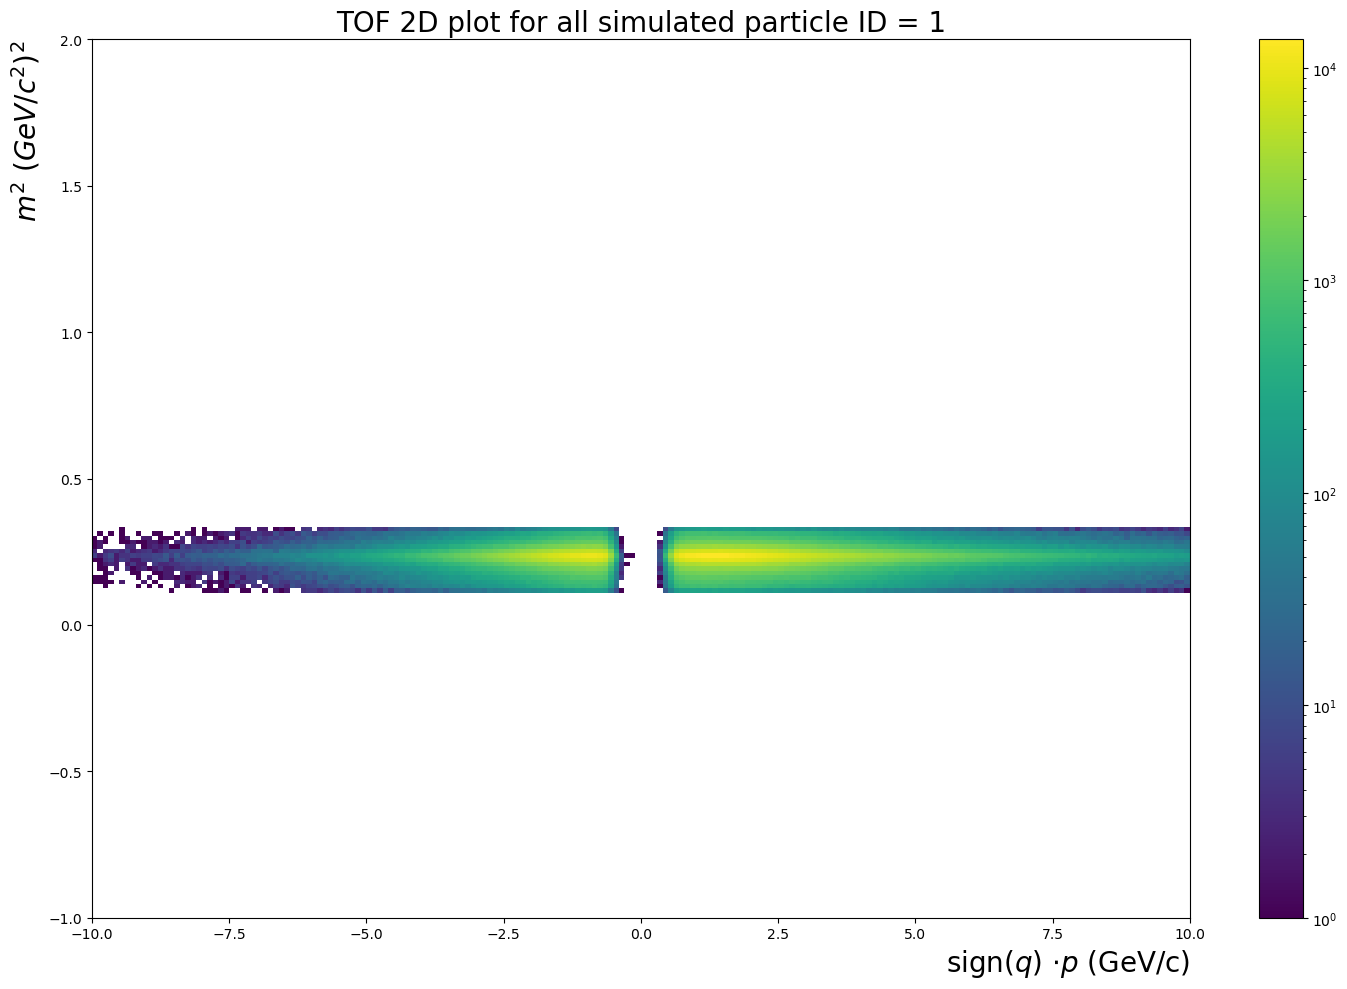

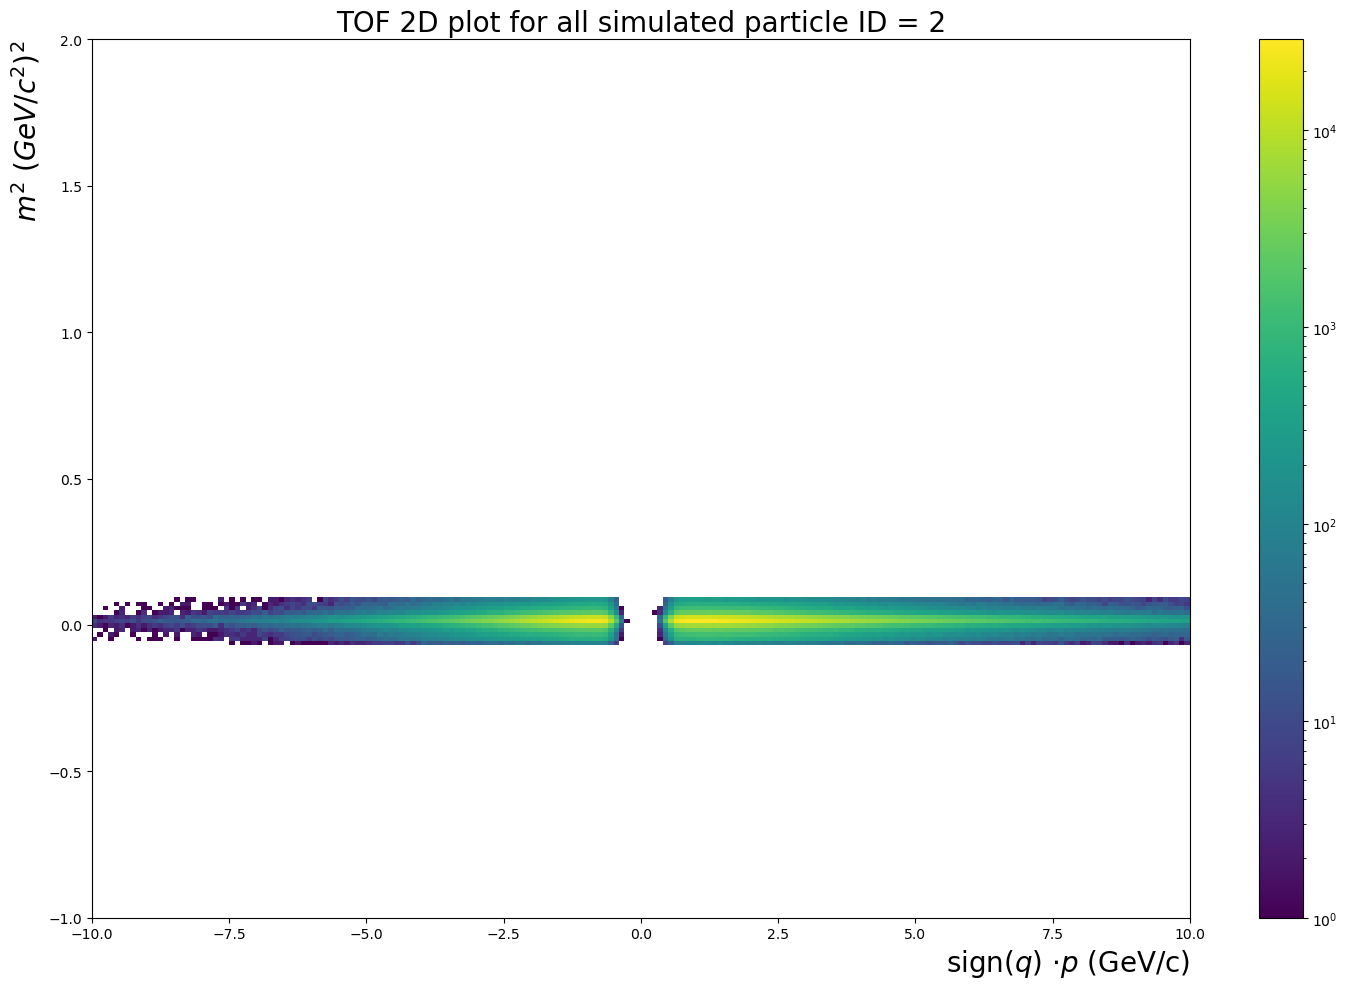

In [17]:
'''after cleaning'''
for i in range(3):
    sim_tof(particles, i)

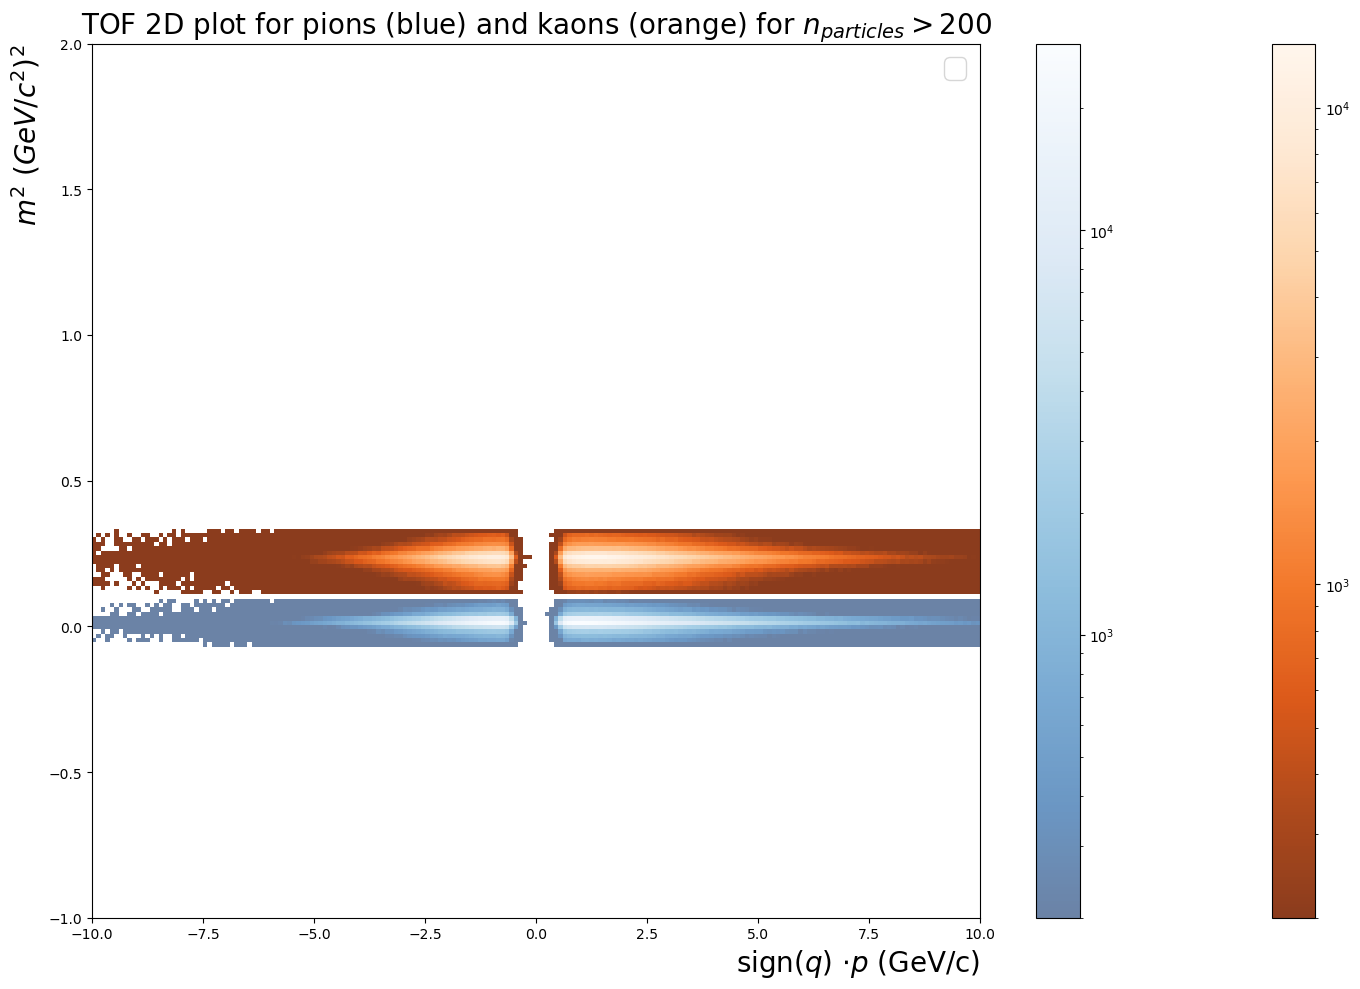

In [18]:
fig, axs = plt.subplots(figsize=(15, 10))

def subplot(pid, name, color, alpha):
    qp = particles[particles['pid']==pid]['q']*particles[particles['pid']==pid]['p']
    mass2 = particles[particles['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)

subplot(1, 'kaons', 'Oranges_r', .9)
subplot(2, 'protons', 'Blues_r', .6)



plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for pions (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()